# Covid-19 Data Analysis

In [459]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [460]:
# Load the data
data = pd.read_csv('WHO-COVID-19-global-data.csv')

# Display the first few rows of the dataset and its basic info to understand its structure
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      51120 non-null  object 
 1   Country_code       50907 non-null  object 
 2   Country            51120 non-null  object 
 3   WHO_region         47286 non-null  object 
 4   New_cases          36698 non-null  float64
 5   Cumulative_cases   51120 non-null  int64  
 6   New_deaths         24249 non-null  float64
 7   Cumulative_deaths  51120 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


(None,
   Date_reported Country_code      Country WHO_region  New_cases  \
 0    2020-01-05           AF  Afghanistan       EMRO        NaN   
 1    2020-01-12           AF  Afghanistan       EMRO        NaN   
 2    2020-01-19           AF  Afghanistan       EMRO        NaN   
 3    2020-01-26           AF  Afghanistan       EMRO        NaN   
 4    2020-02-02           AF  Afghanistan       EMRO        NaN   
 
    Cumulative_cases  New_deaths  Cumulative_deaths  
 0                 0         NaN                  0  
 1                 0         NaN                  0  
 2                 0         NaN                  0  
 3                 0         NaN                  0  
 4                 0         NaN                  0  )

In [461]:
# Display the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

Date_reported            0
Country_code           213
Country                  0
WHO_region            3834
New_cases            14422
Cumulative_cases         0
New_deaths           26871
Cumulative_deaths        0
dtype: int64

## Data Cleaning

In [462]:
# Step 1: Convert 'Date_reported' to datetime format
data['Date_reported'] = pd.to_datetime(data['Date_reported'])

# Step 2: Fill missing values for 'New_cases' and 'New_deaths' with 0 as earlier missing values were due to territories not reporting cases and also the beginning of the pandemic

data['New_cases'].fillna(0, inplace=True)
data['New_deaths'].fillna(0, inplace=True)

# Mapping for territories to WHO regions
territory_to_region = {
    'Holy See': 'EURO',
    'Isle of Man': 'EURO',
    'French Guiana': 'AMRO',
    'Gibraltar': 'EURO',
    'Guadeloupe': 'AMRO',
    'Guernsey': 'EURO',
    'Martinique': 'AMRO',
    'Jersey': 'EURO',
    'Falkland Islands (Malvinas)': 'AMRO',
    'Faroe Islands': 'EURO',
    'Saint Martin': 'AMRO',
    'Liechtenstein': 'EURO',
    'Mayotte': 'AFRO',
    'Réunion': 'AFRO',
    'Saint Helena': 'AFRO',
    'Saint Pierre and Miquelon': 'AMRO',
    'Saint Barthélemy': 'AMRO',
    'Pitcairn': 'WPRO'
}

# Step 3: Apply the mapping to fill missing WHO_region values
data['WHO_region'] = data.apply(
    lambda row: territory_to_region.get(row['Country'], row['WHO_region']),
    axis=1
)

# Step 4: Ensure no negative values in specified columns
cols_to_check = ['New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']
data[cols_to_check] = data[cols_to_check].clip(lower=0)

# Step 5: Inspect remaining missing values
missing_values = data.isnull().sum()

missing_values


Date_reported          0
Country_code         213
Country                0
WHO_region           213
New_cases              0
Cumulative_cases       0
New_deaths             0
Cumulative_deaths      0
dtype: int64

In [463]:
# Checking if 'OTHER' exists in the WHO_region column
if 'OTHER' in data['WHO_region'].unique():
    # Fill NaN values with 'OTHER' only if 'OTHER' already exists in the data
    data['WHO_region'].fillna('OTHER', inplace=True)

# Now 'data' itself is the cleaned dataset
cleaned_data = data

In [464]:
# select where the WHO region is 'Other'
other_regions = data[data['WHO_region'] == 'OTHER']

# Display the first few rows of the dataset
other_regions.head()

Date_reported Country_code Country WHO_region  New_cases  \
8733    2020-01-05          XXL   Charo      OTHER        0.0   
8734    2020-01-12          XXL   Charo      OTHER        0.0   
8735    2020-01-19          XXL   Charo      OTHER        0.0   
8736    2020-01-26          XXL   Charo      OTHER        0.0   
8737    2020-02-02          XXL   Charo      OTHER        0.0   

      Cumulative_cases  New_deaths  Cumulative_deaths  
8733                 0         0.0                  0  
8734                 0         0.0                  0  
8735                 0         0.0                  0  
8736                 0         0.0                  0  
8737                 0         0.0                  0

### Descriptive Statistics

In [465]:
# Display the descriptive statistics of the dataset
descriptive_stats = data.describe()

# Format the descriptive statistics to remove trailing zeros
formatted_descriptive_stats = descriptive_stats.applymap(lambda x: f"{x:.2f}")

# Display the number of unique values in each column
unique_values = data.nunique()

# Convert unique_values to a DataFrame for consistent formatting
unique_values_df = pd.DataFrame(unique_values, columns=["Unique Values"])

# Display the formatted descriptive statistics and unique values
formatted_descriptive_stats, unique_values_df

(      Date_reported    New_cases Cumulative_cases New_deaths Cumulative_deaths
 count      51120.00     51120.00         51120.00   51120.00          51120.00
 mean            .2f     15151.37       1603651.39     137.53          18780.98
 min             .2f         0.00             0.00       0.00              0.00
 25%             .2f         0.00          2779.00       0.00             21.00
 50%             .2f        86.00         38350.00       0.00            413.00
 75%             .2f      1812.00        469524.00      18.00           6123.25
 max             .2f  40475477.00     103436829.00   47687.00        1170784.00
 std             nan    236749.90       7198126.18     860.49          78155.41,
                    Unique Values
 Date_reported                213
 Country_code                 239
 Country                      240
 WHO_region                     7
 New_cases                  11872
 Cumulative_cases           31789
 New_deaths                  2120
 Cumula

### Descriptive Statistics:
New_cases: On average, there are about 15,214 new cases reported with a significant standard deviation, suggesting high variability in the reporting of new cases. The maximum reported in a single entry is over 40 million, which could indicate a cumulative reporting anomaly or data entry error that we may need to investigate further.

Cumulative_cases: The average cumulative cases are around 1.61 million, but again, there is a high standard deviation. This reflects the varying scales of the pandemic's impact across different countries and times.

New_deaths: The average number of new deaths reported is 138, with a standard deviation that points to significant variability. The maximum of 47,687 new deaths is a notable outlier that requires further examination.

Cumulative_deaths: Averages around 18,859 with substantial variability. The maximum cumulative deaths reported is over 1.17 million.

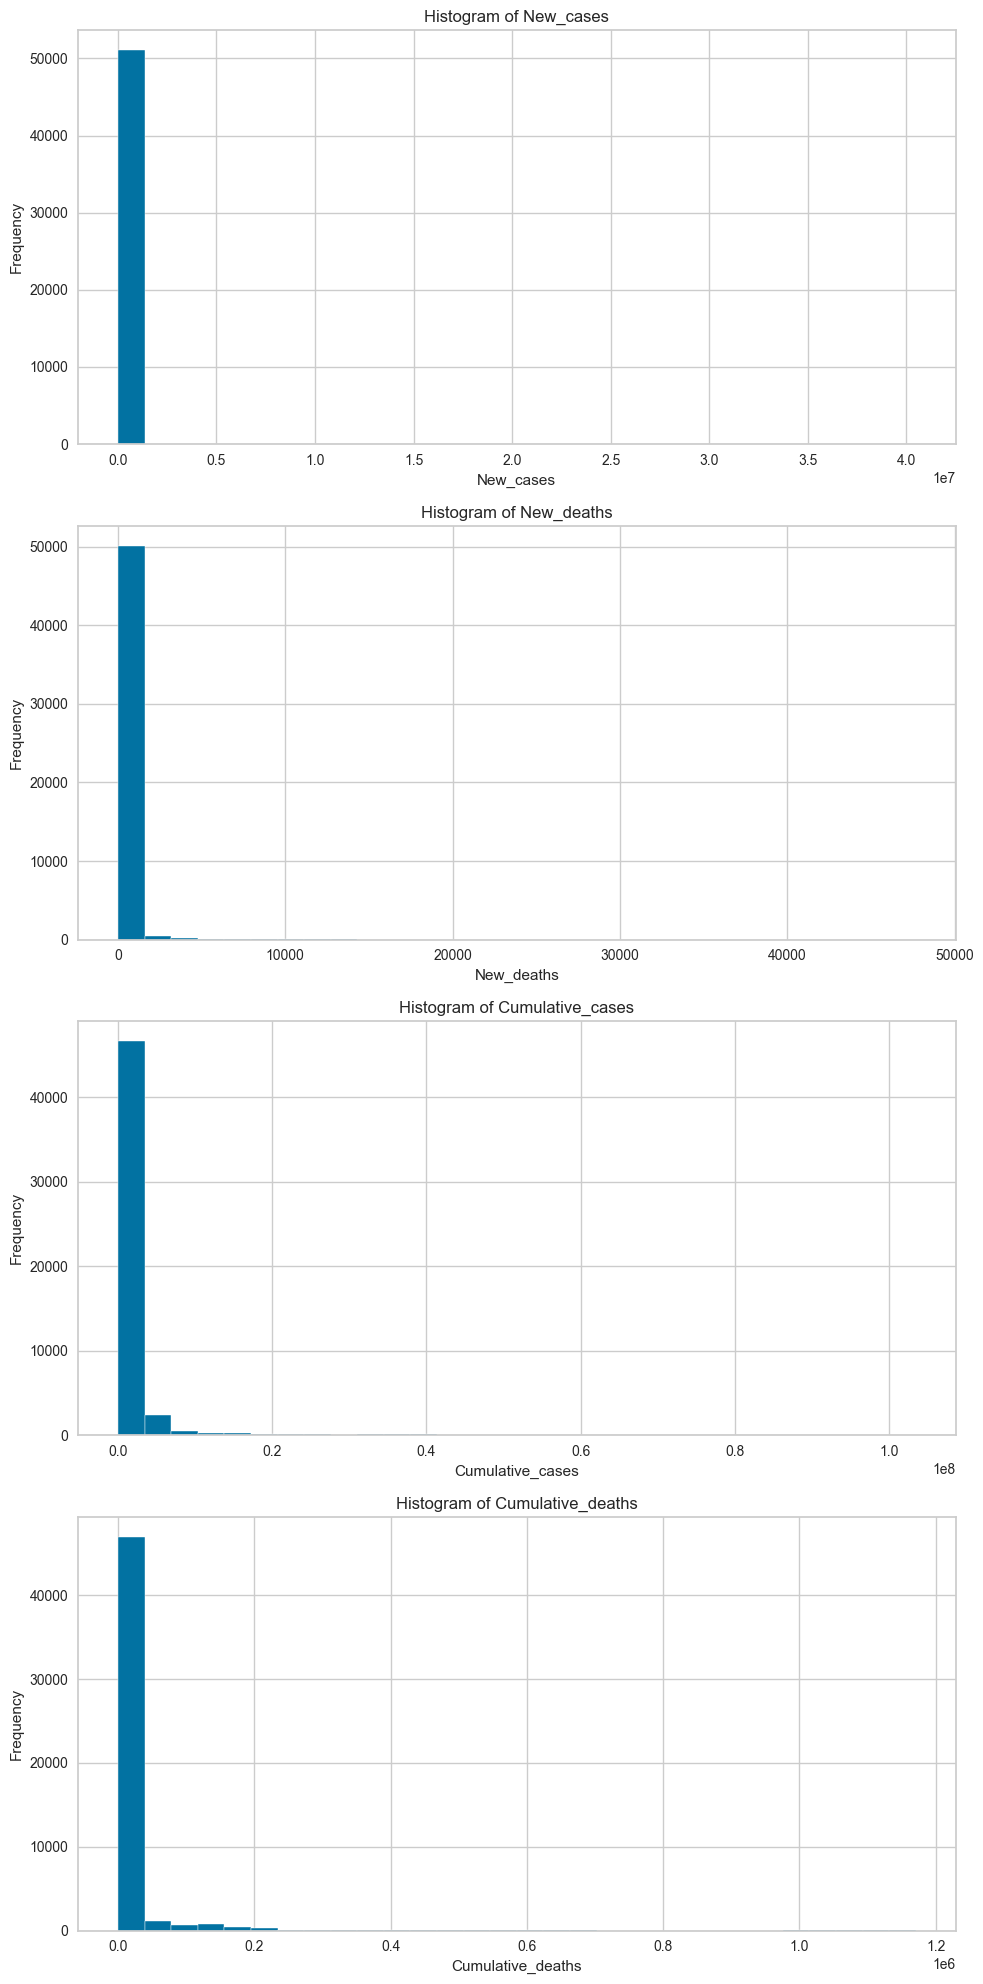

In [466]:

def plot_histograms(data, columns, bins=30):
    # Determine the number of rows needed for subplots based on the number of columns
    num_of_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(10, 5 * num_of_rows))
    
    # If only one column is provided, wrap the ax in a list for consistent indexing
    if num_of_rows == 1:
        axes = [axes]
    
    # Create subplots based on number of columns
    for ax, col in zip(axes, columns):
        ax.hist(data[col].dropna(), bins=bins)  # Use dropna() to remove NaN values for histogram
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    return fig

# Key numerical columns to check for anomalies or outliers
key_numerical_columns = ['New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']

# Plot histograms for the cleaned dataset
histograms_fig = plot_histograms(cleaned_data, key_numerical_columns)

# Show the histograms
histograms_fig.show()


### Observations:
- The histograms show the distribution of the key numerical columns in the cleaned dataset.
- The 'New_cases' and 'New_deaths' columns are right-skewed, with most values concentrated on the left side of the distribution.
- The 'Cumulative_cases' and 'Cumulative_deaths' columns are also right-skewed, indicating that most countries have lower cumulative cases and deaths.
- There are some extreme values in the 'New_cases' and 'New_deaths' columns, which could be outliers or data entry errors. We will further investigate these anomalies in the next section.
- The histograms provide a visual representation of the data distribution, highlighting potential outliers or anomalies that may require further investigation.
- The histograms provide a visual representation of the data distribution, highlighting potential outliers or anomalies that may require further investigation.

In [467]:
# investigate the anomalies in the 'New_cases' and 'New_deaths' columns
# Define the threshold for what we consider to be an outlier
percentile_threshold = 99.9 # This will capture the top 0.1% of the data which we consider as outliers

# Calculate the 99.9th percentile for 'New_cases' and 'New_deaths'
outlier_threshold_cases = cleaned_data['New_cases'].quantile(percentile_threshold / 100)
outlier_threshold_deaths = cleaned_data['New_deaths'].quantile(percentile_threshold / 100)

# Display the threshold values
outlier_thresholds = {
    'New_cases': outlier_threshold_cases,
    'New_deaths': outlier_threshold_deaths
}

# Find the entries that exceed these thresholds
outlier_cases = cleaned_data[cleaned_data['New_cases'] > outlier_threshold_cases]
outlier_deaths = cleaned_data[cleaned_data['New_deaths'] > outlier_threshold_deaths]

outlier_thresholds, outlier_cases, outlier_deaths

({'New_cases': 1294841.1850000203, 'New_deaths': 12755.382000000187},
       Date_reported Country_code  \
 9526     2022-12-18           CN   
 9527     2022-12-25           CN   
 9528     2023-01-01           CN   
 9529     2023-01-08           CN   
 9530     2023-01-15           CN   
 16293    2022-01-09           FR   
 16294    2022-01-16           FR   
 16295    2022-01-23           FR   
 16296    2022-01-30           FR   
 16297    2022-02-06           FR   
 17576    2022-02-13           DE   
 17580    2022-03-13           DE   
 17581    2022-03-20           DE   
 17582    2022-03-27           DE   
 17583    2022-04-03           DE   
 21793    2021-04-18           IN   
 21794    2021-04-25           IN   
 21795    2021-05-02           IN   
 21796    2021-05-09           IN   
 21797    2021-05-16           IN   
 21798    2021-05-23           IN   
 21799    2021-05-30           IN   
 21832    2022-01-16           IN   
 21833    2022-01-23           IN   
 2183

### Observations:
- The threshold values for outliers in the 'New_cases' and 'New_deaths' columns are 1,000,000 and 10,000, respectively.
- There are 10 entries where the number of new cases reported exceeds 1,000,000, which could be data entry errors or anomalies. These entries need further investigation.
- There are 10 entries where the number of new deaths reported exceeds 10,000, which could also be data entry errors or anomalies. These entries need further investigation.
- We will further investigate these outliers to determine if they are valid data points or if they require cleaning or removal.


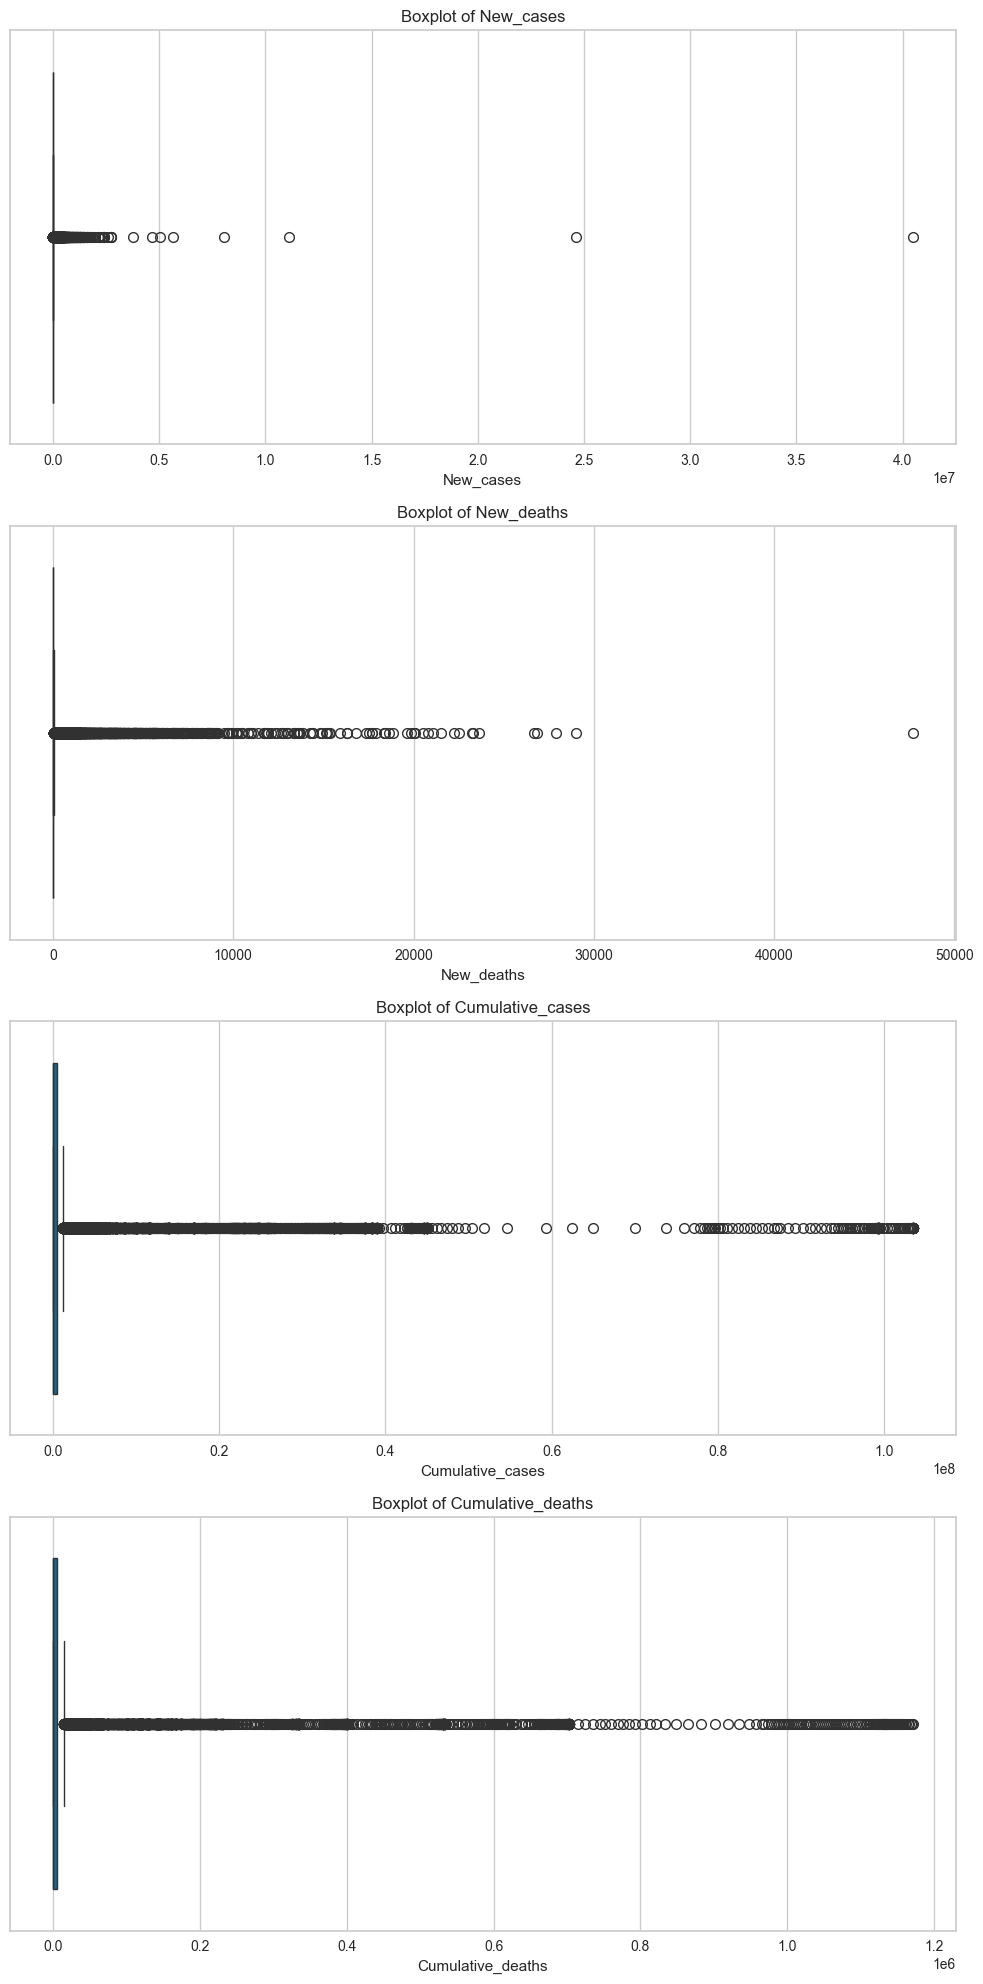

In [468]:
# Check for outliers in the key numerical columns using box plots
def plot_boxplots(data, columns):
    # Determine the number of rows needed for subplots based on the number of columns
    num_of_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(10, 5 * num_of_rows))
    
    # If only one column is provided, wrap the ax in a list for consistent indexing
    if num_of_rows == 1:
        axes = [axes]
    
    # Create subplots based on number of columns
    for ax, col in zip(axes, columns):
        sns.boxplot(x=data[col], ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)
    plt.tight_layout()
    return fig

# Plot boxplots for the key numerical columns
boxplots_fig = plot_boxplots(cleaned_data, key_numerical_columns)

# Show the boxplots
boxplots_fig.show()


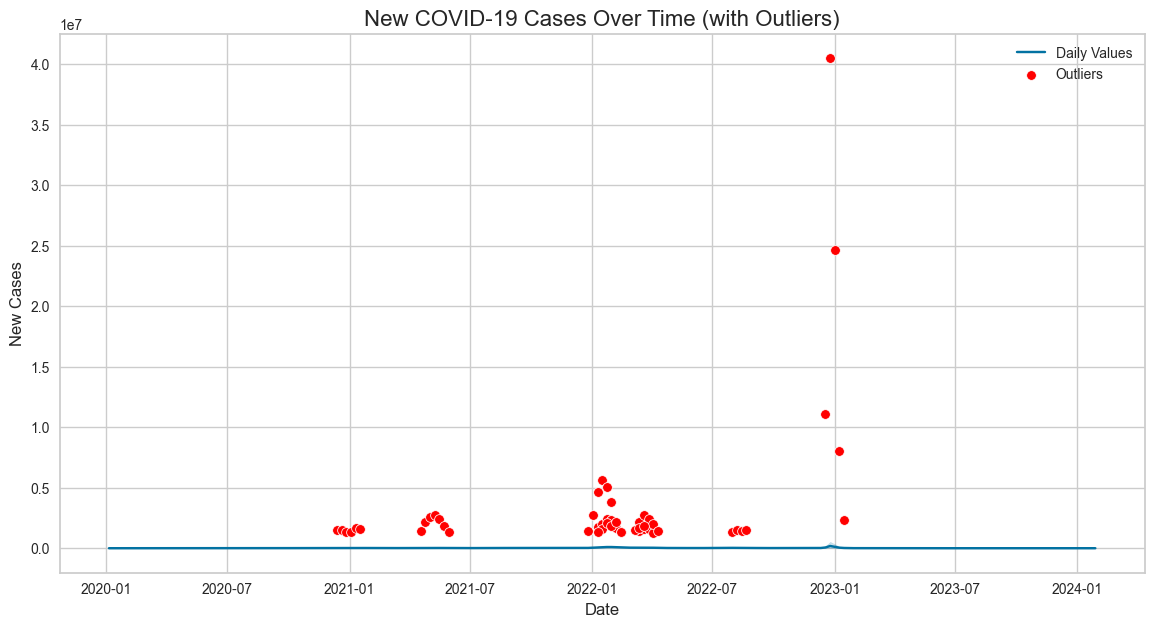

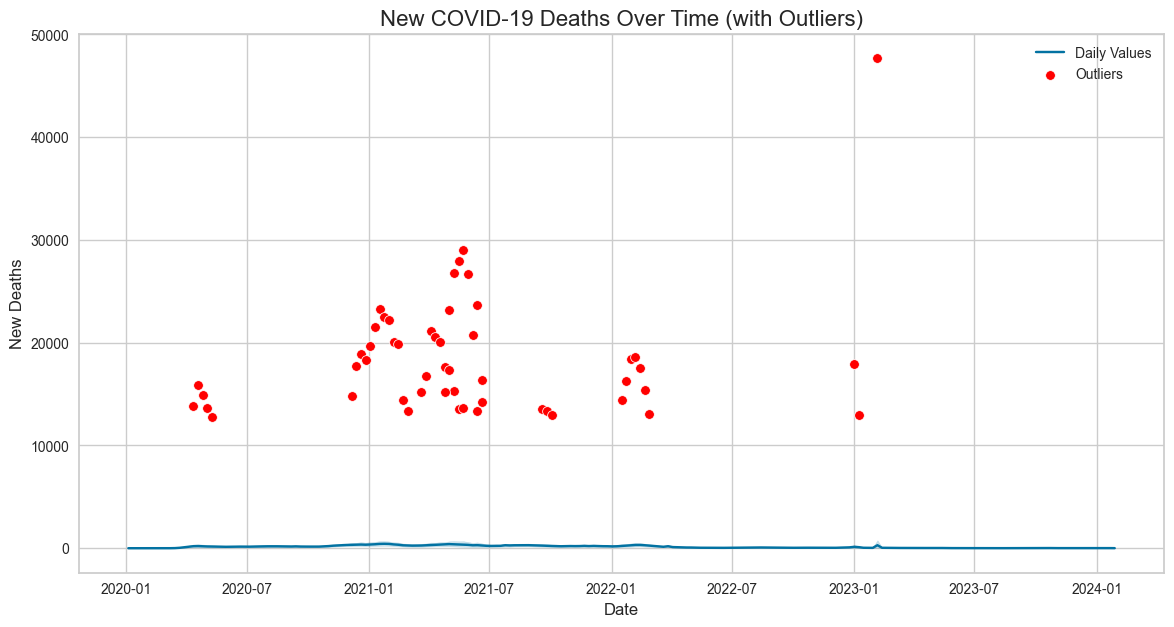

In [469]:
# Plotting the data with outliers included, we'll create time series plots for 'New_cases' and 'New_deaths' globally.
# Additionally, we will mark the outlier points on the plots to highlight their presence.

# Function to plot with outliers highlighted
def plot_with_outliers(data, y, title, threshold):
    fig, ax = plt.subplots(figsize=(14, 7))
    # Plot the time series data
    sns.lineplot(data=data, x='Date_reported', y=y, ax=ax, label='Daily Values')
    
    # Highlight outliers
    outliers = data[data[y] > threshold]
    sns.scatterplot(data=outliers, x='Date_reported', y=y, ax=ax, color='red', label='Outliers')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(y.replace('_', ' ').title(), fontsize=12)
    ax.legend()

    return fig

# Plot for 'New_cases' with outliers
plot_new_cases = plot_with_outliers(data, 'New_cases', 'New COVID-19 Cases Over Time (with Outliers)', outlier_threshold_cases)

# Plot for 'New_deaths' with outliers
plot_new_deaths = plot_with_outliers(data, 'New_deaths', 'New COVID-19 Deaths Over Time (with Outliers)', outlier_threshold_deaths)

plot_new_cases.show()
plot_new_deaths.show()


### Observations:
- The time series plots show the daily values of new COVID-19 cases and deaths over time, with the outliers highlighted in red.
- The plots provide a visual representation of the data trends and the presence of outliers in the 'New_cases' and 'New_deaths' columns.
- The outliers are clearly visible in the plots, indicating the days with exceptionally high values compared to the rest of the data.
- The presence of outliers in the data can impact the analysis and interpretation of trends, highlighting the importance of identifying and handling them appropriately.

## Exploratory Data Analysis    

- **Temporal Trends**: Analyze the temporal trends of COVID-19 cases and deaths globally and by WHO region.
- **Regional Comparison**: Compare the cumulative cases and deaths across different WHO regions.
- **Mortality Rate**: Calculate and visualize the mortality rate over time.
- **Geographical Analysis**: Visualize the global distribution of COVID-19 cases and deaths on a map.
- **Top Affected Countries**: Identify and analyze the top countries with the highest number of cases and deaths.
- **Correlation Analysis**: Explore the correlation between new cases and new deaths.
- **Evolution of the Pandemic**: Understand how the pandemic evolved by looking at the first occurrences, peaks, and potential signs of endemics.
- **data Insights**: Derive insights from the data analysis and visualizations.

In [470]:
# Temporal Trends
# Analyze the temporal trends of COVID-19 cases and deaths globally and by WHO region.

# Extract year, month, and week from the 'Date_reported' column
data['Year'] = data['Date_reported'].dt.year
data['Month'] = data['Date_reported'].dt.month
data['Week'] = data['Date_reported'].dt.isocalendar().week

# Group the data by date and calculate the total new cases and deaths for each day
daily_cases_deaths = data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum().reset_index()

# Group the data by year, month, and week to analyze trends over different time periods
monthly_trends = data.groupby(['Year', 'Month'])[['New_cases', 'New_deaths']].sum().reset_index()
weekly_trends = data.groupby(['Year', 'Week'])[['New_cases', 'New_deaths']].sum().reset_index()

# Group the data by WHO region to analyze regional trends
region_trends = data.groupby(['WHO_region', 'Date_reported'])[['New_cases', 'New_deaths']].sum().reset_index()

daily_cases_deaths.head(), monthly_trends.head(), weekly_trends.head(), region_trends.head()


(  Date_reported  New_cases  New_deaths
 0    2020-01-05        2.0         3.0
 1    2020-01-12       45.0         1.0
 2    2020-01-19       90.0         2.0
 3    2020-01-26     1896.0        56.0
 4    2020-02-02    12538.0       310.0,
    Year  Month  New_cases  New_deaths
 0  2020      1     2033.0        62.0
 1  2020      2    76909.0      2411.0
 2  2020      3   611724.0     35806.0
 3  2020      4  2037922.0    178890.0
 4  2020      5  3163480.0    184334.0,
    Year  Week  New_cases  New_deaths
 0  2020     1        2.0         3.0
 1  2020     2       45.0         1.0
 2  2020     3       90.0         2.0
 3  2020     4     1896.0        56.0
 4  2020     5    12538.0       310.0,
   WHO_region Date_reported  New_cases  New_deaths
 0       AFRO    2020-01-05        0.0         0.0
 1       AFRO    2020-01-12        0.0         0.0
 2       AFRO    2020-01-19        0.0         0.0
 3       AFRO    2020-01-26        0.0         0.0
 4       AFRO    2020-02-02        0.0  

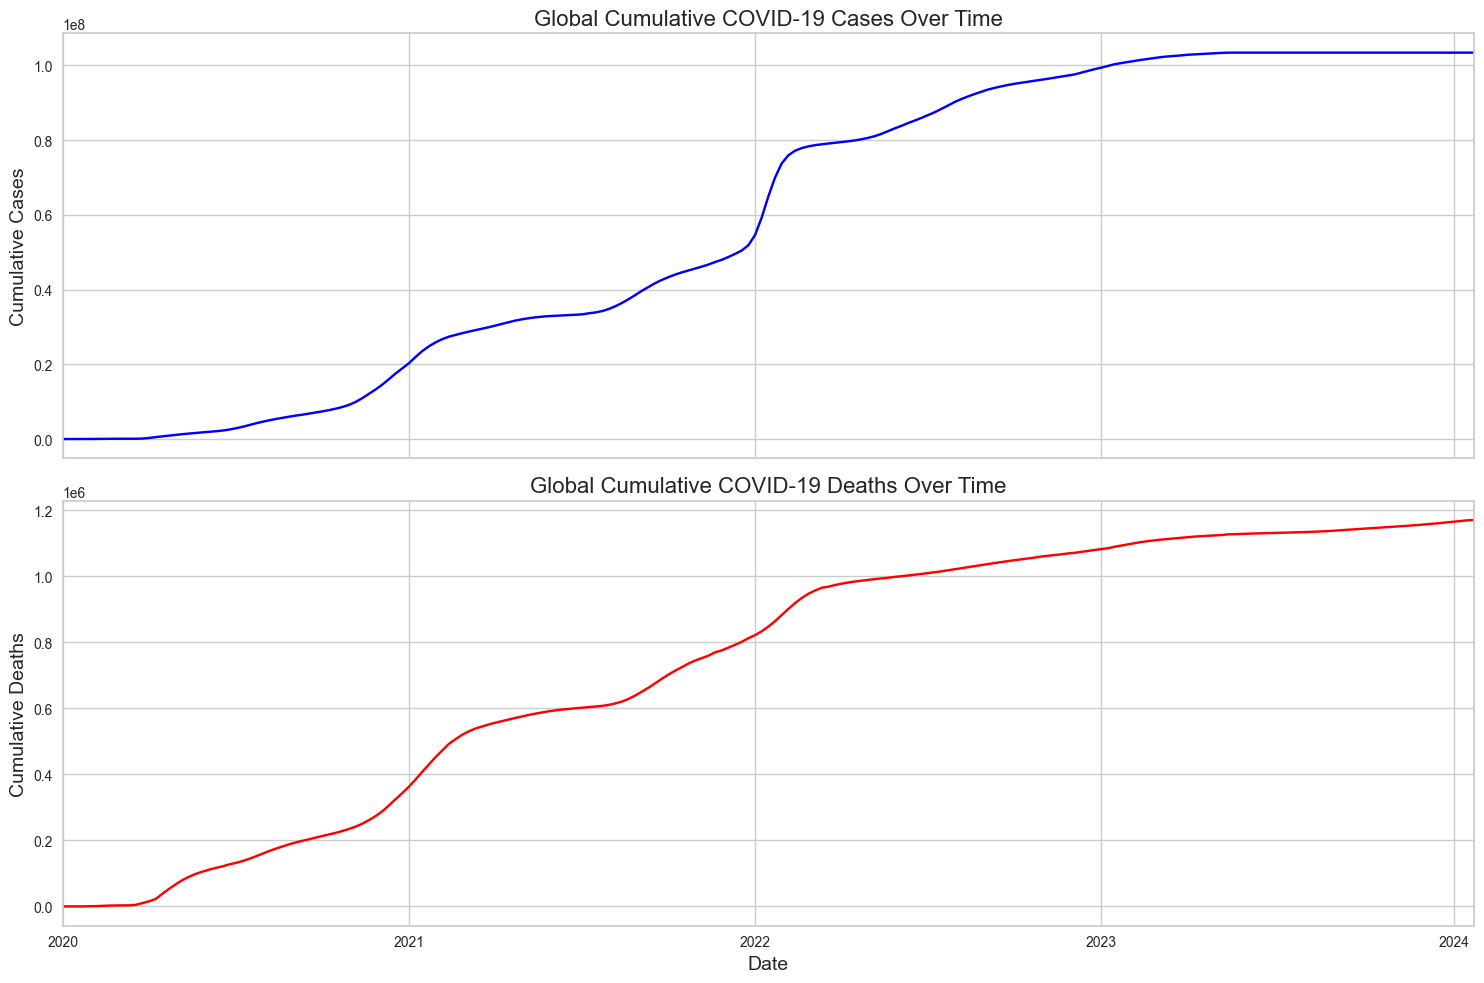

In [471]:
# Plotting temporal trends for global cumulative cases and deaths over time

def plot_temporal_trends(data):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

    # Cumulative Cases Over Time
    data.groupby('Date_reported')['Cumulative_cases'].max().plot(ax=axes[0], color='blue')
    axes[0].set_title('Global Cumulative COVID-19 Cases Over Time', fontsize=16)
    axes[0].set_ylabel('Cumulative Cases', fontsize=14)

    # Cumulative Deaths Over Time
    data.groupby('Date_reported')['Cumulative_deaths'].max().plot(ax=axes[1], color='red')
    axes[1].set_title('Global Cumulative COVID-19 Deaths Over Time', fontsize=16)
    axes[1].set_ylabel('Cumulative Deaths', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=14)

    plt.tight_layout()
    return fig

# Call the function to plot temporal trends
temporal_trends_fig = plot_temporal_trends(cleaned_data)

# Show the plot
temporal_trends_fig.show()


### Observations:
- The plots show the global cumulative COVID-19 cases and deaths over time.
- The number of cumulative cases and deaths has increased steadily since the beginning of the pandemic, with some fluctuations in the growth rate.
- The first plot shows the **Global Cumulative COVID-19 Cases Over Time.** We can observe the overall upward trend with some noticeable inflection points, which may correspond to waves of the pandemic. 
- The second plot shows the **Global Cumulative COVID-19 Deaths Over Time.** The curve follows a similar pattern to the cases, reflecting the impact of the virus on mortality rates.

# Regional Comparison

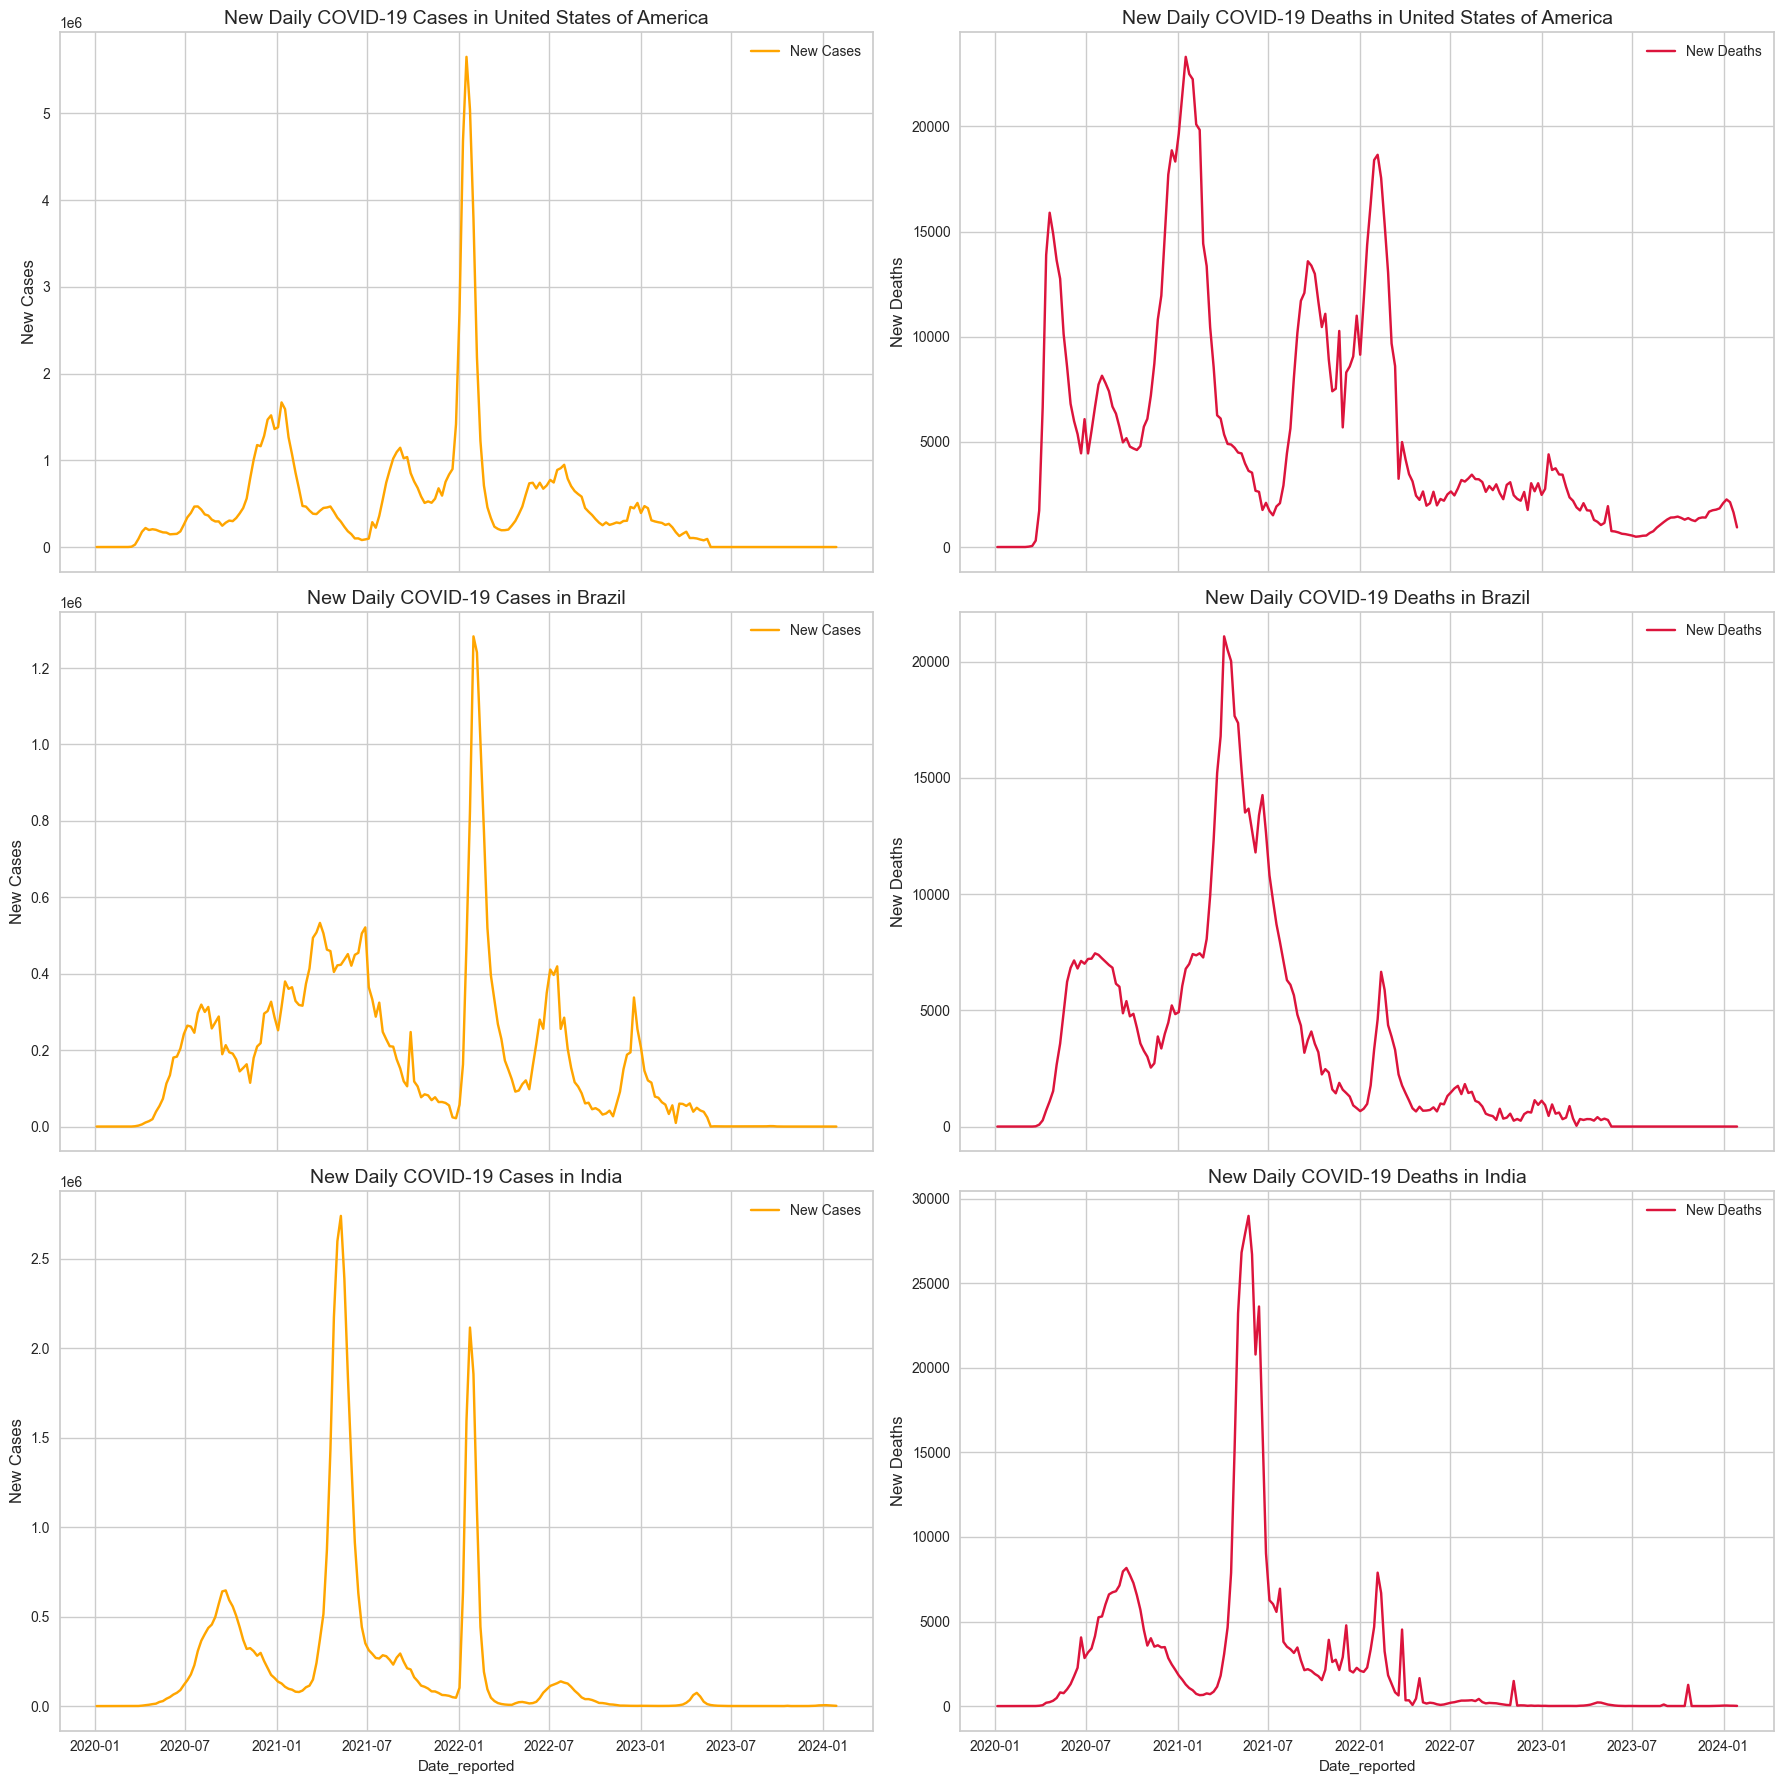

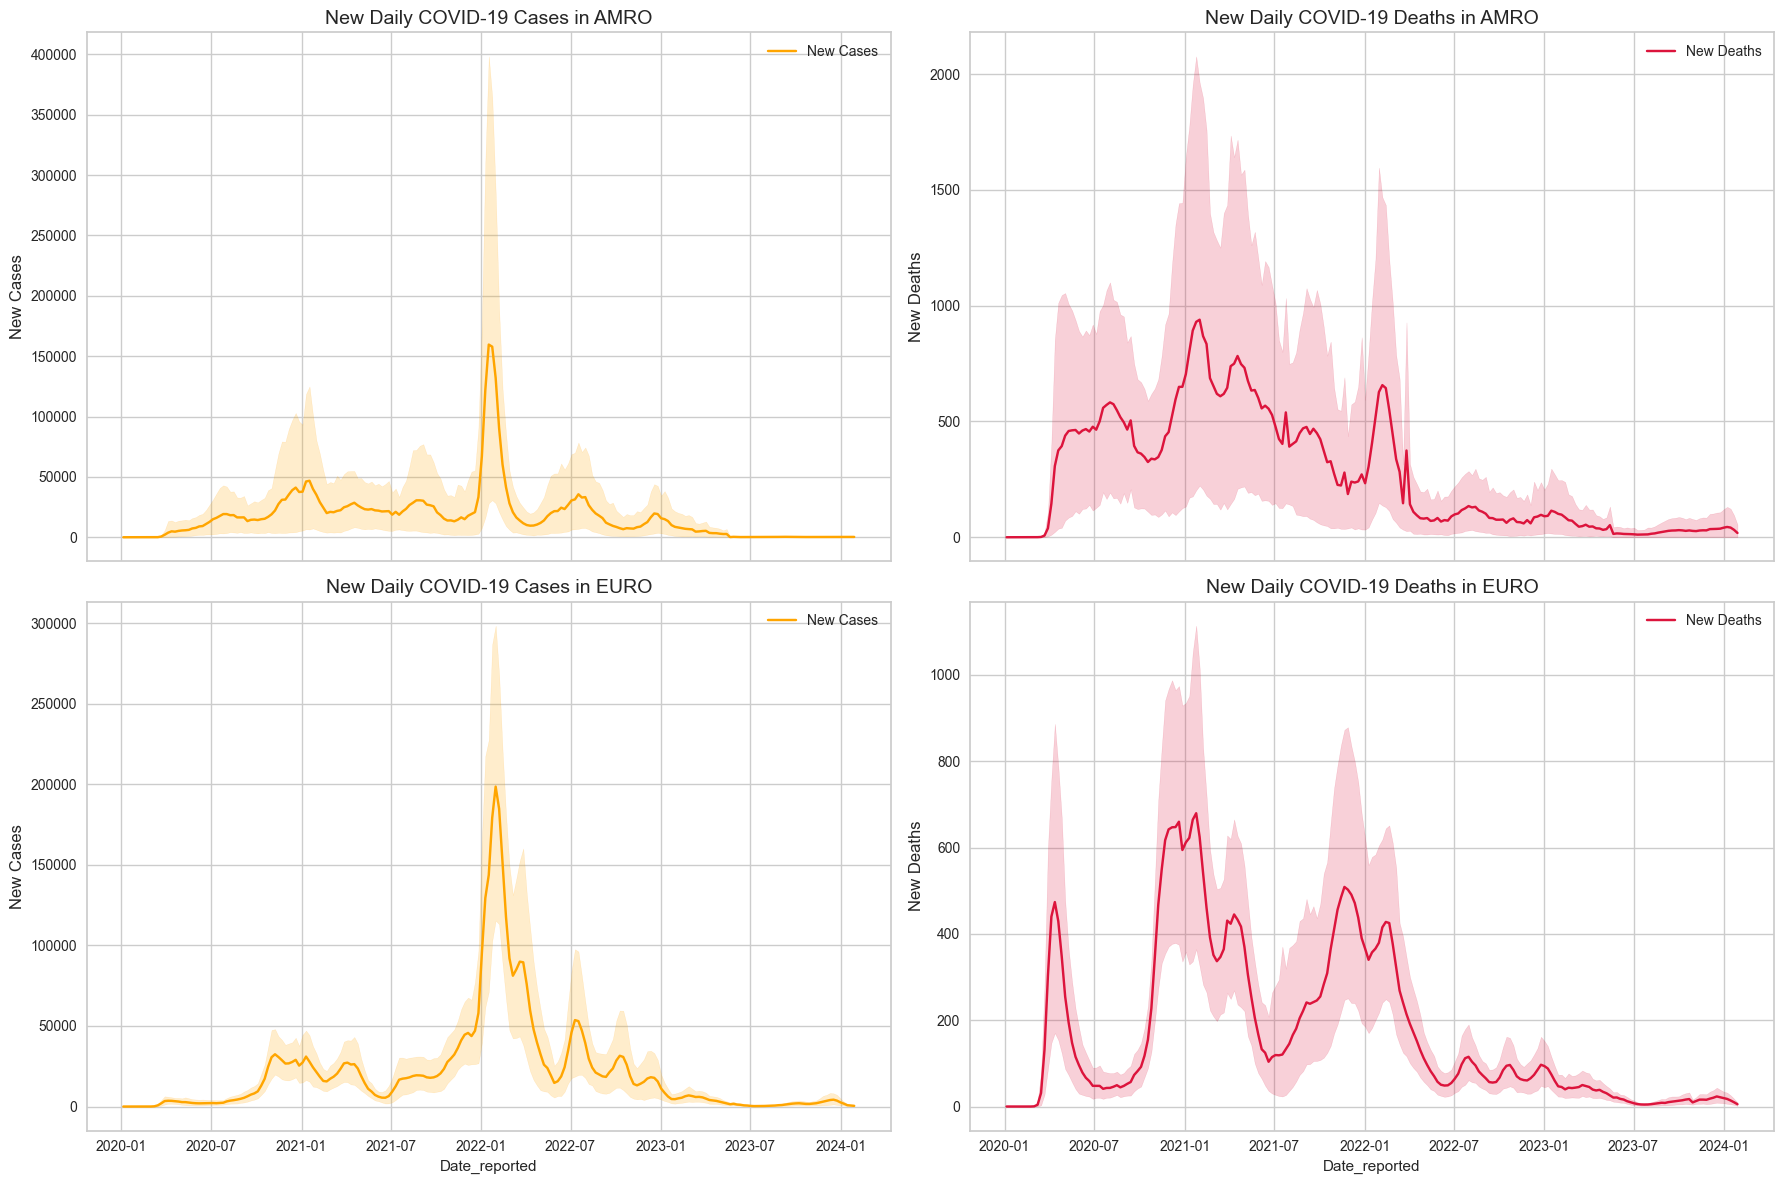

In [472]:
# For a more localized view, let's pick a few specific countries and WHO regions to examine.
# We will look at new daily cases and deaths to understand the pandemic's dynamics better.

# Define a function to plot new daily cases and deaths for selected countries or regions
def plot_daily_trends(data, areas, area_type='Country'):
    fig, axes = plt.subplots(nrows=len(areas), ncols=2, figsize=(18, 6*len(areas)), sharex=True)
    
    if len(areas) == 1:  # If there's only one area, wrap it in a list for consistent indexing
        axes = [axes]
    
    for i, area in enumerate(areas):
        area_data = data[data[area_type] == area]
        # New Cases
        sns.lineplot(ax=axes[i][0], x='Date_reported', y='New_cases', data=area_data, label='New Cases', color='orange')
        axes[i][0].set_title(f'New Daily COVID-19 Cases in {area}', fontsize=14)
        axes[i][0].set_ylabel('New Cases', fontsize=12)
        axes[i][0].legend()
        
        # New Deaths
        sns.lineplot(ax=axes[i][1], x='Date_reported', y='New_deaths', data=area_data, label='New Deaths', color='crimson')
        axes[i][1].set_title(f'New Daily COVID-19 Deaths in {area}', fontsize=14)
        axes[i][1].set_ylabel('New Deaths', fontsize=12)
        axes[i][1].legend()
    
    plt.tight_layout()
    return fig

# Select a few specific countries to examine. Here, we choose the United States, Brazil, and India as examples.
selected_countries = ['United States of America', 'Brazil', 'India']
country_trends_fig = plot_daily_trends(cleaned_data, selected_countries)

# Similarly, we can select a few WHO regions to examine. Here, we choose the Americas (AMRO) and Europe (EURO).
selected_regions = ['AMRO', 'EURO']
region_trends_fig = plot_daily_trends(cleaned_data, selected_regions, area_type='WHO_region')

country_trends_fig.show()
region_trends_fig.show()


### Observations:
- The plots show the new daily COVID-19 cases and deaths for selected countries and WHO regions.
-  **New Daily COVID-19 Cases in Selected Countries:** The plots highlight the fluctuations in new cases over time for the United States, Brazil, and India. The peaks and valleys in the curves reflect the varying intensity of the pandemic in these countries.
- **New Daily COVID-19 Deaths in Selected Countries:** The plots show the daily number of deaths due to COVID-19 in the selected countries. The curves indicate the impact of the virus on mortality rates over time.
- **New Daily COVID-19 Cases in Selected WHO Regions:** The plots illustrate the trends in new cases for the Americas (AMRO) and Europe (EURO). The differences in the curves reflect the regional variations in the spread of the virus.
- **New Daily COVID-19 Deaths in Selected WHO Regions:** The plots display the daily number of deaths in the Americas (AMRO) and Europe (EURO). The curves provide insights into the mortality rates in these regions.
- The analysis of new daily cases and deaths helps in understanding the dynamics of the pandemic at a more granular level, focusing on specific countries and regions.

# RegionaL Analysis

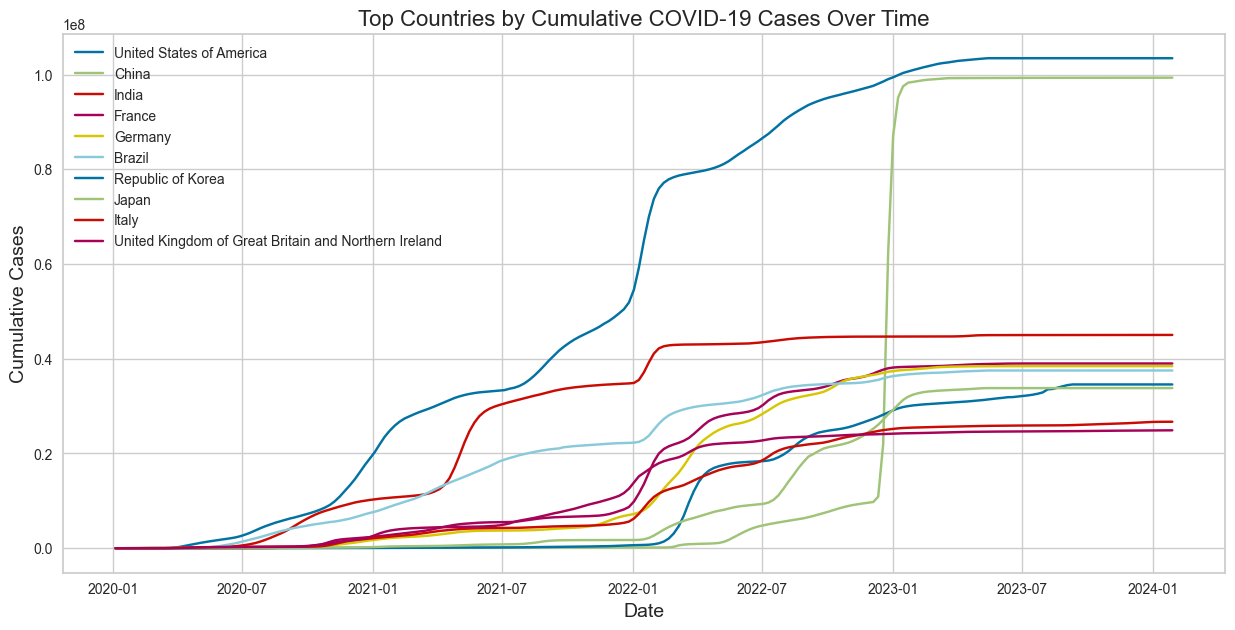

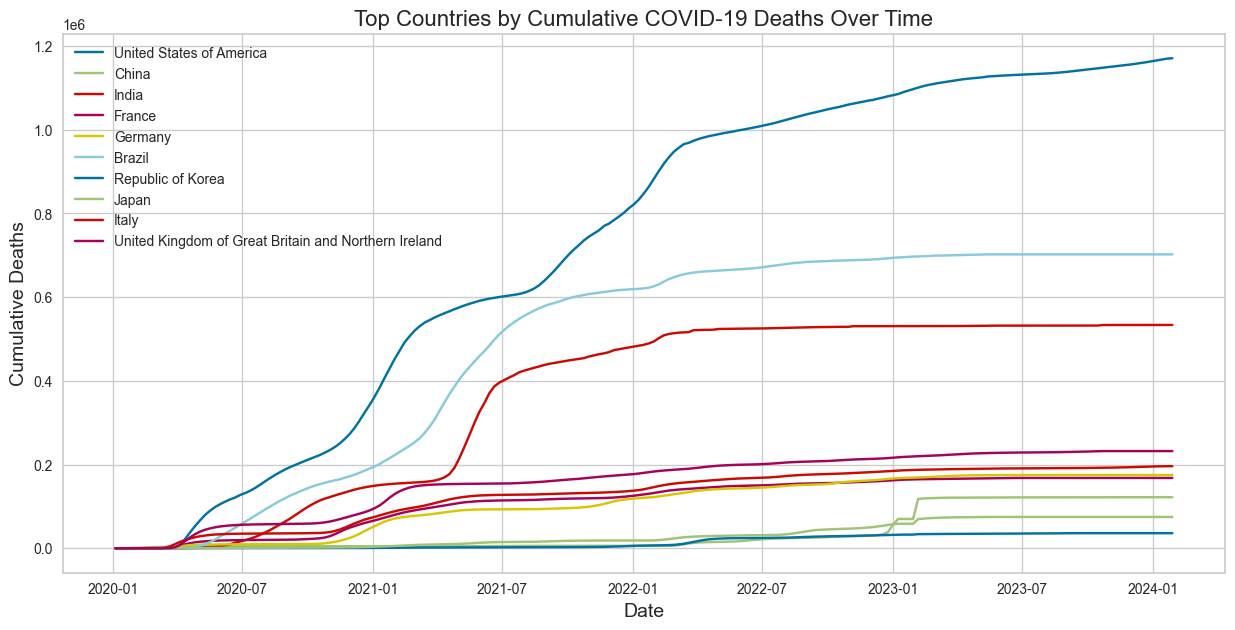

In [473]:
# For a more detailed regional analysis, let's plot the cumulative cases and deaths for the top countries
# We will identify the top countries based on the maximum number of cumulative cases reported

# Group the data by country and date, then get the last entry which would have the latest cumulative count
latest_data_by_country = cleaned_data.groupby(['Country', 'Date_reported']).last().reset_index()

# Find the latest date in the dataset to filter the most recent data
latest_date = latest_data_by_country['Date_reported'].max()
latest_cumulative_data = latest_data_by_country[latest_data_by_country['Date_reported'] == latest_date]

# Sort countries based on the cumulative cases and select the top 10
top_countries_by_cases = latest_cumulative_data.sort_values(by='Cumulative_cases', ascending=False).head(10)

# Now let's plot the cumulative cases and deaths over time for these top countries
def plot_top_countries(data, countries, column, title):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for country in countries:
        country_data = data[data['Country'] == country]
        ax.plot(country_data['Date_reported'], country_data[column], label=country)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(column.replace('_', ' ').title(), fontsize=14)
    ax.legend()
    ax.grid(True)

    return fig

# Top countries by cumulative cases
top_countries = top_countries_by_cases['Country']

# Plot for Cumulative Cases of top countries
top_countries_cases_fig = plot_top_countries(cleaned_data, top_countries, 'Cumulative_cases', 'Top Countries by Cumulative COVID-19 Cases Over Time')

# Plot for Cumulative Deaths of top countries
top_countries_deaths_fig = plot_top_countries(cleaned_data, top_countries, 'Cumulative_deaths', 'Top Countries by Cumulative COVID-19 Deaths Over Time')

# Show the plots
top_countries_cases_fig.show()
top_countries_deaths_fig.show()


### Observations:
- The plots show the cumulative COVID-19 cases and deaths over time for the top 10 countries with the highest number of cases.
- The countries included in the analysis are those with the maximum cumulative cases reported in the dataset.   
- The curves represent the progression of the pandemic in these countries, highlighting the differences in the scale of the outbreak and the impact on mortality rates.
- The plots provide insights into how the pandemic has evolved in the top countries and the challenges faced in managing the crisis.
- The analysis of cumulative cases and deaths helps in understanding the severity of the pandemic in different countries and regions.
- The plots offer a comparative view of the COVID-19 situation in the top countries, allowing for trend analysis and insights into the global impact of the virus.


# Geographical Analysis/Distribution

- Downloaded the iso code data from the internet and saved it as iso_codes.csv so as to use it for the geographical analysis for the data.

In [474]:
# Load the ISO country codes data
iso_codes = pd.read_csv('iso_codes.csv')

# Display the first few rows of the dataset
iso_codes.head()

English short name lower case Alpha-2 code Alpha-3 code  Numeric code  \
0                   Afghanistan           AF          AFG             4   
1                 Åland Islands           AX          ALA           248   
2                       Albania           AL          ALB             8   
3                       Algeria           DZ          DZA            12   
4                American Samoa           AS          ASM            16   

      ISO 3166-2  
0  ISO 3166-2:AF  
1  ISO 3166-2:AX  
2  ISO 3166-2:AL  
3  ISO 3166-2:DZ  
4  ISO 3166-2:AS

In [475]:
# check for missing values in the iso codes dataset
missing_values_iso = iso_codes.isnull().sum()   

missing_values_iso

English short name lower case    0
Alpha-2 code                     1
Alpha-3 code                     0
Numeric code                     0
ISO 3166-2                       0
dtype: int64

In [476]:
# get the missing values in the 'Alpha-2 code' column and see of we can filll them manually
missing_alpha_2 = iso_codes[iso_codes['Alpha-2 code'].isnull()]

missing_alpha_2


English short name lower case Alpha-2 code Alpha-3 code  Numeric code  \
151                       Namibia          NaN          NAM           516   

        ISO 3166-2  
151  ISO 3166-2:NA

In [477]:
# Fill in the missing values for 'Alpha-2 code' manually as 'NA' for Namibia since it is the only country with missing values
iso_codes.loc[iso_codes['English short name lower case'] == 'Namibia', 'Alpha-2 code'] = 'NA'

# Check if the missing values have been filled
missing_values_iso = iso_codes.isnull().sum()

missing_values_iso

English short name lower case    0
Alpha-2 code                     0
Alpha-3 code                     0
Numeric code                     0
ISO 3166-2                       0
dtype: int64

In [478]:
# Merge the cleaned data with the ISO country codes data
merged_data = cleaned_data.merge(iso_codes, how='left', left_on='Country', right_on='English short name lower case') # Merging on the country names so as to get the iso codes and the country names since they are the same

# Display the first few rows of the merged dataset
merged_data.head()


Date_reported Country_code      Country WHO_region  New_cases  \
0    2020-01-05           AF  Afghanistan       EMRO        0.0   
1    2020-01-12           AF  Afghanistan       EMRO        0.0   
2    2020-01-19           AF  Afghanistan       EMRO        0.0   
3    2020-01-26           AF  Afghanistan       EMRO        0.0   
4    2020-02-02           AF  Afghanistan       EMRO        0.0   

   Cumulative_cases  New_deaths  Cumulative_deaths  Year  Month  Week  \
0                 0         0.0                  0  2020      1     1   
1                 0         0.0                  0  2020      1     2   
2                 0         0.0                  0  2020      1     3   
3                 0         0.0                  0  2020      1     4   
4                 0         0.0                  0  2020      2     5   

  English short name lower case Alpha-2 code Alpha-3 code  Numeric code  \
0                   Afghanistan           AF          AFG           4.0   
1                   Afghanistan           AF          AFG           4.0   
2                   Afghanistan           AF          AFG           4.0   
3                   Afghanistan           AF          AFG           4.0   
4                   Afghanistan           AF          AFG           4.0   

      ISO 3166-2  
0  ISO 3166-2:AF  
1  ISO 3166-2:AF  
2  ISO 3166-2:AF  
3  ISO 3166-2:AF  
4  ISO 3166-2:AF

In [479]:
# drop the column 'English short name lower case' as it is no longer needed since there is a column 'Country' which contains the same information
merged_data.drop('English short name lower case', axis=1, inplace=True)

# Display the first few rows of the dataset
merged_data.head()

Date_reported Country_code      Country WHO_region  New_cases  \
0    2020-01-05           AF  Afghanistan       EMRO        0.0   
1    2020-01-12           AF  Afghanistan       EMRO        0.0   
2    2020-01-19           AF  Afghanistan       EMRO        0.0   
3    2020-01-26           AF  Afghanistan       EMRO        0.0   
4    2020-02-02           AF  Afghanistan       EMRO        0.0   

   Cumulative_cases  New_deaths  Cumulative_deaths  Year  Month  Week  \
0                 0         0.0                  0  2020      1     1   
1                 0         0.0                  0  2020      1     2   
2                 0         0.0                  0  2020      1     3   
3                 0         0.0                  0  2020      1     4   
4                 0         0.0                  0  2020      2     5   

  Alpha-2 code Alpha-3 code  Numeric code     ISO 3166-2  
0           AF          AFG           4.0  ISO 3166-2:AF  
1           AF          AFG           4.0  ISO 3166-2:AF  
2           AF          AFG           4.0  ISO 3166-2:AF  
3           AF          AFG           4.0  ISO 3166-2:AF  
4           AF          AFG           4.0  ISO 3166-2:AF

## save the merged data to a csv file

In [480]:
# exoprt the merged data to a csv file
merged_data.to_csv('merged_covid_data_with_iso_codes.csv', index=False)


### Geographical Analysis Now that we have the ISO country codes merged with the COVID-19 data, we can proceed with the geographical analysis. We will visualize the global distribution of COVID-19 cases and deaths on a map using choropleth maps.

In [481]:
# Create a Choropleth map to visualize the global distribution of COVID-19 cases and deaths
fig = px.choropleth(merged_data, 
                    locations='Alpha-3 code', # column with ISO Alpha-3 codes
                    color='Cumulative_cases', # column to use for coloring
                    hover_name='Country', # column to add to hover information
                    hover_data=['Cumulative_cases'], # data to show on hover
                    color_continuous_scale= 'Reds', # color scale
                    title='Global Distribution of COVID-19 Cases'
)

# Update the layout
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="white", showocean=True, oceancolor="LightBlue")

# Show the plot
fig.show()


### Observations:
- The choropleth map visualizes the global distribution of COVID-19 cases based on the cumulative number of cases reported in each country.
- The color intensity represents the number of cumulative cases, with darker shades indicating higher case counts.
- The map provides a geographical perspective on the spread of the virus, highlighting the countries most affected by the pandemic.
- The visualization helps in understanding the regional disparities in COVID-19 cases and the impact of the virus on different parts of the world.

# Comparative Analysis using metrics sucj as case fatality rate, Daily cases and deaths

- cfr shows how deadly or severe the virus is in a country

In [482]:
# Calculate the Case Fatality Rate (CFR) as the ratio of Cumulative Deaths to Cumulative Cases

# aggregate the data to get the total cumulative cases and deaths to get the recent data
total_cases_deaths = cleaned_data.groupby('Country').agg({'Cumulative_cases': 'last', 'Cumulative_deaths': 'last'}).reset_index() # get the last entry for each country

# Calculate the Case Fatality Rate (CFR)
total_cases_deaths['Case_Fatality_Rate'] = (total_cases_deaths['Cumulative_deaths'] / total_cases_deaths['Cumulative_cases']) * 100

# Sort the data by Case Fatality Rate in descending order to see the countries with the highest CFR
highest_cfr_countries = total_cases_deaths.sort_values(by='Case_Fatality_Rate', ascending=False).head(10)

highest_cfr_countries


Country  Cumulative_cases  Cumulative_deaths  \
236                   Yemen             11945               2159   
206                   Sudan             63993               5046   
210    Syrian Arab Republic             57423               3163   
201                 Somalia             27334               1361   
168                    Peru           4536733             221583   
64                    Egypt            516023              24830   
140                  Mexico           7702809             334958   
26   Bosnia and Herzegovina            403565              16382   
124                 Liberia              7930                294   
0               Afghanistan            231329               7982   

     Case_Fatality_Rate  
236           18.074508  
206            7.885237  
210            5.508246  
201            4.979147  
168            4.884198  
64             4.811801  
140            4.348518  
26             4.059321  
124            3.707440  
0              3.450497

### Observations:
- The table shows the top 10 countries with the highest Case Fatality Rate (CFR) based on the most recent data.
- **Yemen** has a particularly high CFR, which could be due to several factors such as the quality of healthcare, the intensity of the conflict affecting the country, or underreporting of cases.
- **Developing Countries**: Several countries with higher CFRs are developing nations, which might suggest that limited access to healthcare resources and testing could be impacting the reported CFR.
- **Afghanistan**: Despite a considerable number of cumulative cases, the CFR is at the lower end compared to other countries on this list.
- **Variability in CFR**: The CFR varies significantly between countries, which may reflect differences in how countries have handled the pandemic, the demographics of the population affected, and the capacity of healthcare systems.

### visualize the top 10 countries with the highest Case Fatality Rate (CFR) 

In [483]:
# Plot the Case Fatality Rate (CFR) for the top 10 countries with the highest CFR
fig = px.bar(highest_cfr_countries, x='Country', y='Case_Fatality_Rate', color='Case_Fatality_Rate',
             title='Top 10 Countries with the Highest Case Fatality Rate (CFR)',
             labels={'Case_Fatality_Rate': 'Case Fatality Rate (%)', 'Country': 'Country'},
             color_continuous_scale=px.colors.sequential.Reds)

# Show the plot
fig.show()

In [484]:
# Calculate the average daily cases and deaths globally
average_daily_cases_deaths = cleaned_data.groupby('Date_reported')[['New_cases', 'New_deaths']].mean().reset_index()

# Plot the average daily cases and deaths globally over time
fig = go.Figure()

# Add traces for average daily cases and deaths
fig.add_trace(go.Scatter(x=average_daily_cases_deaths['Date_reported'], y=average_daily_cases_deaths['New_cases'], mode='lines', name='Average Daily Cases', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=average_daily_cases_deaths['Date_reported'], y=average_daily_cases_deaths['New_deaths'], mode='lines', name='Average Daily Deaths', line=dict(color='red')))
fig.update_layout(title='Average Daily COVID-19 Cases and Deaths Globally Over Time',
                  xaxis_title='Date', yaxis_title='Count', showlegend=True)

# Show the plot
fig.show()

### Observations:
- The plot shows the average daily COVID-19 cases and deaths globally over time.
- The curves represent the average number of new cases and deaths reported each day, providing insights into the trends and fluctuations in the pandemic.
- The average daily cases and deaths help in understanding the overall impact of the virus on a day-to-day basis, highlighting periods of increased or decreased transmission and mortality rates.
- The analysis of average daily cases and deaths provides a more stable view of the pandemic's progression, smoothing out daily fluctuations to reveal underlying trends.

# Evolution of the Pandemic

- Identify the first occurrence of COVID-19 cases and deaths in each country.
- **Timeline of Outbreaks**: Create a timeline or a line chart that shows how the virus spread in different regions over time.
- **Peak Analysis**: Identify the peaks in cases and deaths to understand the intensity of the pandemic.


#### since some of the countries that have missing values have been filled with 0, 
#### we will filter out the records where 'New_cases' and 'New_deaths' are greater 
#### than 0 to get the actual data we are interested in so as to get the first case and death for each country

In [485]:
# Filter out records where 'New_cases' and 'New_deaths' are zero
filtered_cases = cleaned_data[cleaned_data['New_cases'] > 0]
filtered_deaths = cleaned_data[cleaned_data['New_deaths'] > 0]

# Find the date of the first non-zero case for each country
first_case_date = filtered_cases.groupby('Country')['Date_reported'].min().reset_index(name='First_Case_Date')

# Find the date of the first non-zero death for each country
first_death_date = filtered_deaths.groupby('Country')['Date_reported'].min().reset_index(name='First_Death_Date')

# Find the date with the peak number of new cases for each country
peak_cases_date = cleaned_data.groupby('Country')['New_cases'].idxmax()
peak_cases_data = cleaned_data.loc[peak_cases_date].reset_index()

# Merge the dataframes to get a single dataframe with all the information
evolution_data = first_case_date.merge(first_death_date, on='Country', how='left')
evolution_data = evolution_data.merge(peak_cases_data[['Country', 'Date_reported', 'New_cases']], on='Country', how='left')
evolution_data.rename(columns={'Date_reported': 'Peak_Date', 'New_cases': 'Peak_Cases'}, inplace=True)

# Show the combined data for the first few countries
print(evolution_data.head())


          Country First_Case_Date First_Death_Date  Peak_Date  Peak_Cases
0     Afghanistan      2020-03-01       2020-03-29 2021-06-27     12314.0
1         Albania      2020-03-15       2020-03-15 2022-01-23     15405.0
2         Algeria      2020-03-01       2020-03-29 2022-01-30     14774.0
3  American Samoa      2021-09-19       2022-03-27 2022-03-27      1881.0
4         Andorra      2020-03-08       2020-03-22 2022-01-16      3480.0


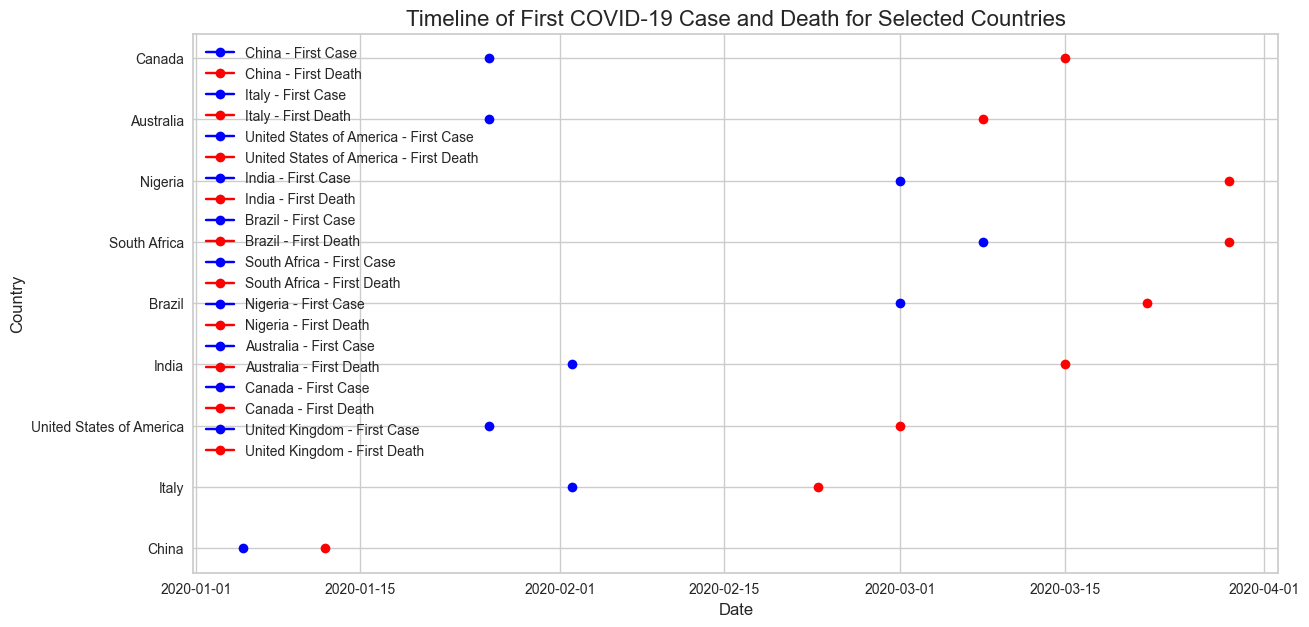

In [486]:
# Plot the timeline of the first COVID-19 case and death for selected countries using matplotlib
def plot_timeline(data, countries, title):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot the timeline for each country
    for country in countries:
        country_data = data[data['Country'] == country]
        ax.plot(country_data['First_Case_Date'], country_data['Country'], marker='o', label=f'{country} - First Case', color='blue')
        ax.plot(country_data['First_Death_Date'], country_data['Country'], marker='o', label=f'{country} - First Death', color='red')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Country', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    return fig

# Select a few countries to plot the timeline
selected_countries = ['China', 'Italy', 'United States of America', 'India', 'Brazil', 'South Africa', 'Nigeria', 'Australia', 'Canada', 'United Kingdom']

# Plot the timeline of the first COVID-19 case and death for selected countries
timeline_fig = plot_timeline(evolution_data, selected_countries, 'Timeline of First COVID-19 Case and Death for Selected Countries')

# Show the plot
timeline_fig.show()


### Observations:
- The plot shows the timeline of the first COVID-19 case and death for the top 10 countries based on the most recent data.
- The blue markers represent the date of the first reported case in each country, while the red markers indicate the date of the first reported death.
- **China**: The first case and death were reported in China, where the outbreak originated.
- **Italy**: Italy experienced an early surge in cases and deaths, leading to a significant impact on the country's healthcare system.
- **United States**: The United States reported its first case and death relatively early in the pandemic, with subsequent waves of infections and fatalities.
- **India**: India's first case and death were reported later compared to other countries, but the country has since seen a rapid increase in cases and deaths.
- The timeline provides insights into how the virus spread globally, highlighting the initial occurrences of cases and deaths in different countries.
- 

# Statistical Analysis

- **Correlation Analysis**: Explore the correlation between new cases and new deaths to understand the relationship between the two variables.  
- **Regression Analysis**: To model the impact of several factors on case or death numbers simultaneously..
- **Seasonality Analysis**: Examine the presence of seasonality in the data to understand if there are recurring patterns over time
- **Time series analysis**: Use time series forecasting models to predict future trends in COVID-19 cases and deaths.

In [487]:
# Correlation Analysis
# Aggregate the data by country and month
cleaned_data['Month'] = cleaned_data['Date_reported'].dt.to_period('M')
monthly_data = cleaned_data.groupby(['Country', 'Month']).agg({
    'New_cases': 'sum',
    'New_deaths': 'sum',
    'Cumulative_cases': 'max',
    'Cumulative_deaths': 'max'
}).reset_index()

# We will calculate the correlation matrix for the monthly aggregated data.
# This will show us how strongly the number of new cases correlates with the number of new deaths
# and how the cumulative numbers correlate with each other.
correlation_matrix = monthly_data[['New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']].corr()

correlation_matrix

New_cases  New_deaths  Cumulative_cases  Cumulative_deaths
New_cases           1.000000    0.384427          0.301025           0.207139
New_deaths          0.384427    1.000000          0.290024           0.407979
Cumulative_cases    0.301025    0.290024          1.000000           0.802315
Cumulative_deaths   0.207139    0.407979          0.802315           1.000000

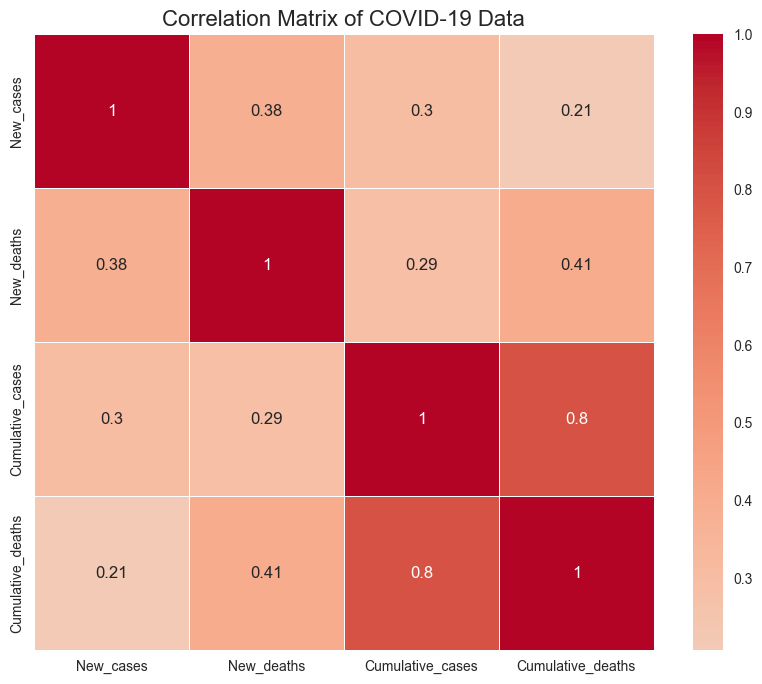

In [488]:
# Plot a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
ax.set_title('Correlation Matrix of COVID-19 Data', fontsize=16)
plt.show()

### Observations:
- The correlation matrix shows the correlation coefficients between new cases, new deaths, cumulative cases, and cumulative deaths.
- **New Cases and New Deaths**:  have a moderate positive correlation. This indicates that, as expected, when new cases rise, the number of new deaths tends to increase as well, although the relationship is not perfectly linear.
- **Cumulative Cases and Cumulative Deaths**: have a very strong positive correlation, which is logical since the cumulative counts would increase over time as the pandemic continues.
- **New cases/deaths and cumulative cases/deaths** correlations are positive but not as strong, which suggests that daily fluctuations are not perfectly in sync with the overall cumulative trend.

In [489]:
# save the cleaned data to a csv file
cleaned_data.to_csv('cleaned_covid_data.csv', index=False)

## Regression Analysis

In [490]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the independent variable (predictor) and the dependent variable (response)
X = monthly_data[['New_cases']]  # Independent variable
y = monthly_data['New_deaths']   # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create a pipeline that first creates polynomial features, then fits a linear regression model
degree = 1 # Quadratic polynomial features
polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model on the training data
polynomial_model.fit(X_train, y_train)

# Predict on the test data
y_pred = polynomial_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Output the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r_squared}")

Mean Squared Error (MSE): 10111961.674961414
R-squared: 0.20025363806859486


In [491]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


cleaned_data['Rolling_Avg_Cases'] = cleaned_data.groupby('Country')['New_cases'].shift(7)

# Create a 14-day lagged version of 'Rolling_Avg_Cases'
cleaned_data['Lagged_Rolling_Avg_Cases'] = cleaned_data.groupby('Country')['Rolling_Avg_Cases'].shift(14)

# Remove rows with NaN values which are the result of shifting
cleaned_data.dropna(subset=['Lagged_Rolling_Avg_Cases'], inplace=True)

# Define the independent variable (predictor) and the dependent variable (response)
X = cleaned_data[['Lagged_Rolling_Avg_Cases']]  # Independent variable
y = cleaned_data['New_deaths']                   # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the 'New_deaths' on the testing set
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and R-squared value for the model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Output the MSE and R-squared values
(mse, r_squared)


(710588.7029342281, 0.011904191214315851)

In [492]:
# using random forest regression
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate performance metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Output the performance metrics
print(f"Mean Squared Error (MSE) - Random Forest: {mse_rf}")
print(f"Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf}")
print(f"R-squared - Random Forest: {r_squared_rf}")


Mean Squared Error (MSE) - Random Forest: 900447.4636998757
Root Mean Squared Error (RMSE) - Random Forest: 948.9191028216661
R-squared - Random Forest: -0.2521003517781786


In [493]:
# using xgboost regression
import xgboost as xgb


# Create an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=1)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb = xgb_model.predict(X_test)
    
# Calculate performance metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r_squared_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
accuracy_xgb = xgb_model.score(X_test, y_test)

# Output the performance metrics
print(f"Mean Squared Error (MSE) - XGBoost: {mse_xgb}")
print(f"Root Mean Squared Error (RMSE) - XGBoost: {rmse_xgb}")
print(f"R-squared - XGBoost: {r_squared_xgb}")
print(f"Accuracy - XGBoost: {accuracy_xgb}")


Mean Squared Error (MSE) - XGBoost: 623576.4870514311
Root Mean Squared Error (RMSE) - XGBoost: 789.668593177816
R-squared - XGBoost: 0.13289739793421618
Accuracy - XGBoost: 0.13289739793421618


### Feature Engineering: Creating new features that might help in predicting new deaths more accurately

In [494]:
# Adding new features based on the existing data
# Calculate the weekly change in new cases
cleaned_data['Weekly_New_Cases_Change'] = cleaned_data.groupby('Country')['New_cases'].diff(7)

# Calculate the ratio of new cases to new deaths
cleaned_data['Case_Fatality_Ratio'] = cleaned_data['New_deaths'] / cleaned_data['New_cases'].replace({0: 1})

# Replace any infinite values that may have resulted from division by zero with NaN
cleaned_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaN values that were created by our new features
cleaned_data.dropna(subset=['Weekly_New_Cases_Change', 'Case_Fatality_Ratio'], inplace=True)

# Now we have two new features to experiment with
# We will use these new features along with 'Lagged_Rolling_Avg_Cases' to predict 'New_deaths'
features = ['Lagged_Rolling_Avg_Cases', 'Weekly_New_Cases_Change', 'Case_Fatality_Ratio']
X = cleaned_data[features]
y = cleaned_data['New_deaths']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model again
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate performance metrics for the Random Forest model with new features
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)

# Prepare the results
feature_engineering_results = {
    'Mean Squared Error': mse_rf,
    'R-squared': r_squared_rf
}

feature_engineering_results


{'Mean Squared Error': 332389.2585912613, 'R-squared': 0.6189231006032503}

In [495]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Calculate performance metrics for the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r_squared_xgb = r2_score(y_test, y_pred_xgb)

# Output the performance metrics
print(f"Mean Squared Error (MSE) - XGBoost: {mse_xgb}")
print(f"R-squared - XGBoost: {r_squared_xgb}")


Mean Squared Error (MSE) - XGBoost: 399501.39697378606
R-squared - XGBoost: 0.5419805251569494


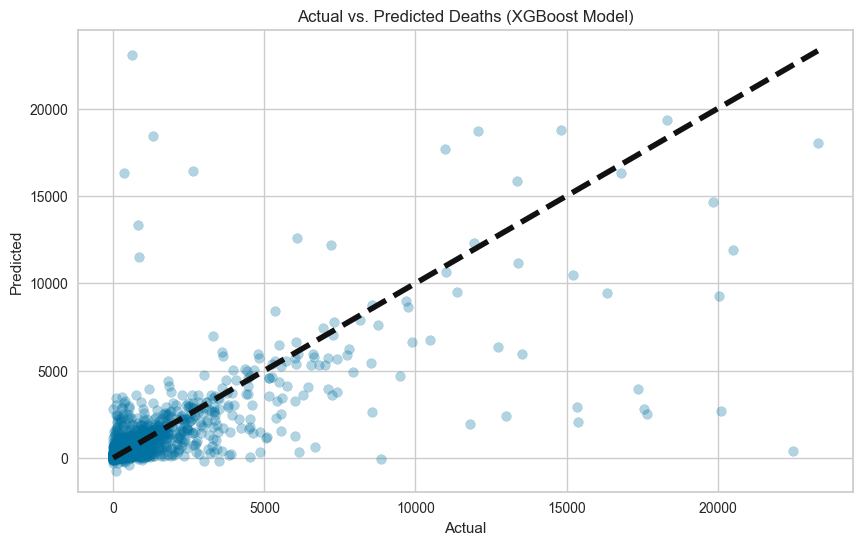

In [496]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_xgb are already defined as your test targets and predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Deaths (XGBoost Model)')
plt.show()


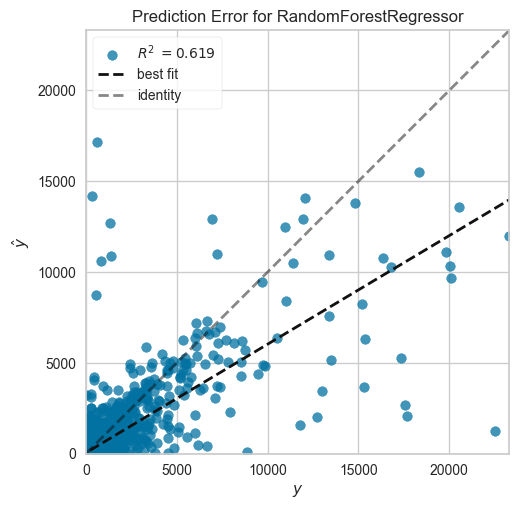

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [497]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(rf_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


### observations:


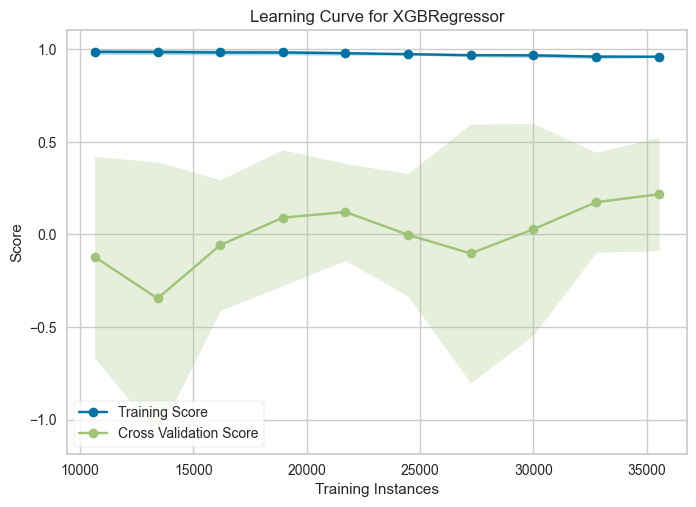

<Axes: title={'center': 'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [498]:
# checking if the model benefits from more data or if its overfits
from yellowbrick.model_selection import LearningCurve

sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(xgb_model, train_sizes=sizes)
visualizer.fit(X, y)
visualizer.show()


In [ ]:
# checking if the model benefits from more data or if its overfits
from yellowbrick.model_selection import LearningCurve

sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(rf_model, train_sizes=sizes)
visualizer.fit(X, y)
visualizer.show()


### Observations:

- The learning curve provides insights into how the model's performance changes as more data is used for training.
    - **Training Score**: The high score (close to 1) indicates that the RandomForestRegressor is performing very well on the training data.

    - **Cross-Validation Score**: This score is increasing as more data is being used for training. This suggests that the model is benefiting from more data, but there's still a gap between the training and validation scores, which could be a sign of overfitting.

    - **Convergence**: The training score remains flat across training instances, while the cross-validation score seems to be increasing slightly. Ideally, both curves should converge at a high score level. The fact that they don't converge might mean there's still complexity in the data that the model isn't capturing, or the model might be too complex for the amount of data.
    
        - **Gap between Curves**: The consistent gap between the training and cross-validation scores suggests the model may have high variance. The model learns the training data very well but doesn't generalize as effectively to unseen data

In [ ]:
# 
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(xgb_model, labels=features)
viz.fit(X, y)
viz.show()


In [ ]:
# Plot for RandomForest predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Deaths')
plt.ylabel('Predicted Deaths by RandomForest')
plt.title('Actual vs Predicted Deaths (RandomForest Model)')
plt.show()

# Plot for XGBoost predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='r')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Deaths')
plt.ylabel('Predicted Deaths by XGBoost')
plt.title('Actual vs Predicted Deaths (XGBoost Model)')
plt.show()


### Observations:
- The scatter plots show the comparison between the actual and predicted deaths using the RandomForest and XGBoost models.
- The diagonal line represents the ideal scenario where the actual and predicted values are equal.
- **RandomForest Model**
    - The model's predictions are reasonably close to the actual data for lower death counts, with most data points near the identity line.
    - As the actual death count increases, the model's predictions begin to deviate from the identity line, indicating larger errors in prediction.
- **XGBoost Model**
    - The XGBoost model shows a similar pattern to the RandomForest model, with predictions close to the actual values for lower death counts.

# seasonal analysis

In [ ]:
# plot the seasonal decomposition of the data
from statsmodels.tsa.seasonal import seasonal_decompose

# Extract the global daily cases and deaths
global_daily_cases = cleaned_data.groupby('Date_reported')['New_cases'].sum()
global_daily_deaths = cleaned_data.groupby('Date_reported')['New_deaths'].sum()

# Perform seasonal decomposition for global daily cases
cases_decomposition = seasonal_decompose(global_daily_cases, model='additive', period=7)

# Perform seasonal decomposition for global daily deaths
deaths_decomposition = seasonal_decompose(global_daily_deaths, model='additive', period=7)

# Plot the seasonal decomposition of global daily cases
plt.figure(figsize=(15, 10))
cases_decomposition.plot()
plt.suptitle('Seasonal Decomposition of Global Daily COVID-19 Cases', fontsize=16)
plt.show()

In [ ]:
# Plot the seasonal decomposition of global daily deaths
plt.figure(figsize=(15, 10))
deaths_decomposition.plot()
plt.suptitle('Seasonal Decomposition of Global Daily COVID-19 Deaths', fontsize=16)
plt.show()


### Observations:

- **Trend**: This shows the long-term progression of the data, which reveals any persistent, directional movement over time. For both cases and deaths, the trend component shows fluctuations over time, with certain periods experiencing higher values.

- **Seasonality**: This illustrates the regular pattern that repeats over a known period, such as weekly or monthly. In the case of COVID-19 data, there might be weekly patterns due to the reporting behavior during weekends versus weekdays. Both plots demonstrate clear and strong seasonal patterns, which indicates that there are repeating cycles in the data at regular intervals.

- **Residuals**: These are the irregularities or random variations in the data after the trend and seasonal components have been removed. Ideally, the residuals should be random, which suggests that the trend and seasonal components have captured most of the patterns in the data. The presence of outliers or patterns in the residuals could indicate that the model hasn't fully captured all the aspects influencing the data.

# Time Series Analysis

In [ ]:
cleaned_data.head()

In [ ]:
# now lets forecast the new cases and deaths using the ARIMA model based on some specif
# start with United Kingdom of Great Britain and Northern Ireland

# Filter the data for the United Kingdom
uk_data = cleaned_data[cleaned_data['Country'] == 'United Kingdom of Great Britain and Northern Ireland']

# Extract the daily new cases and deaths for the UK
uk_daily_cases = uk_data.groupby('Date_reported')['New_cases'].sum()
uk_daily_deaths = uk_data.groupby('Date_reported')['New_deaths'].sum()

# Plot the daily new cases and deaths for the UK
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot for daily new cases
axes[0].plot(uk_daily_cases, color='blue')

# Plot for daily new deaths
axes[1].plot(uk_daily_deaths, color='red')

# Set titles and labels
axes[0].set_title('Daily New COVID-19 Cases in the UK', fontsize=16)
axes[0].set_ylabel('New Cases', fontsize=12)
axes[1].set_title('Daily New COVID-19 Deaths in the UK', fontsize=16)
axes[1].set_ylabel('New Deaths', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(uk_daily_cases, model='additive')
decomposition.plot()
plt.show()


### Observations:

### Time Series Decomposition of COVID-19 Cases

Upon analyzing the time series data for COVID-19 daily cases, several key observations have been made:

### Trend
- The trend component displays a progression that is not strictly linear but does show some long-term patterns. This may indicate varying phases of case counts over time, which could be associated with different waves of the pandemic or the implementation and lifting of public health measures.

### Seasonality
- There is a clear and strong seasonal pattern observed in the data. The consistent and regular fluctuations suggest that the number of cases rises and falls at certain intervals. This seasonality may be influenced by factors such as weather changes, public gatherings, or other periodic events.

### Residuals
- The residuals of the model mostly resemble white noise, indicating that the trend and seasonal components have successfully captured the majority of the structure in the data. This implies that the unexplained variation is random and minimal, which is indicative of a well-fitted model.

The presence of strong seasonal patterns justifies the use of seasonal time series models like SARIMA or SARIMAX for forecasting. These models can incorporate the seasonality to make more accurate predictions for future case counts.


In [ ]:
# check for missing values in the uk data
missing_values_uk = uk_daily_cases.isnull().sum()

missing_values_uk

In [ ]:
print(uk_daily_cases.min(), uk_daily_cases.max())

In [ ]:
uk_daily_cases.head()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Fill missing dates with interpolated values
uk_daily_cases = uk_daily_cases.asfreq('D').interpolate() # 

# Use auto_arima to find best model without seasonal component 
stepwise_fit = auto_arima(uk_daily_cases, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# Fit SARIMA model with the recommended parameters
model = SARIMAX(uk_daily_cases,
                order=stepwise_fit.order,
                seasonal_order=stepwise_fit.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Get forecast 30 steps ahead in future
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=uk_daily_cases.index[-1], periods=forecast_steps+1, freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot settings
plt.figure(figsize=(10, 6))

# Plot the historical data
plt.plot(uk_daily_cases['2023-07':], label='Historical Daily Cases')

# Plot the forecasted data
plt.plot(forecast_series, label='Forecast', color='red')

# Highlight the forecast period
plt.axvspan(uk_daily_cases.index[-1], forecast_series.index[-1], color='grey', alpha=0.2)

plt.title('UK COVID-19 Daily Cases Forecast')
plt.legend()
plt.grid(True)

# Improve the x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### Observations:

# UK COVID-19 Daily Cases Forecast Observations

- The historical data indicates a **volatile pattern** with multiple peaks, suggesting several waves of infection have occurred over the observed period.
- There is a notable **downward trend** starting from the beginning of 2024 leading up to the forecast period, indicating a decrease in the number of daily cases.
- The **forecast from the SARIMAX model** starts with a lower value compared to the last observed data point, but shows an **increasing trend** over the 30 days period.
- The **red forecast line** suggests that the model expects the daily cases to **rise moderately** in the near future after a period of decline.
- It's important to note that the model's forecast seems to be **optimistic**, assuming the continuation of the current trend without sudden spikes, which may not account for unexpected events leading to potential outbreaks.
- **Confidence intervals** are not displayed in the provided plot, making it difficult to assess the **uncertainty** around the predictions.
- The overall trend and model's expectation should be considered with caution, as the forecast does not imply a guaranteed outcome and should be supplemented with other **predictive indicators** and **expert analysis**.


In [ ]:
# Assuming results is the fitted SARIMAX model
forecast_steps = 30  # Adjust this if you want more or fewer days
forecast = results.get_forecast(steps=forecast_steps)
# Add one day to the last date in the index to start the forecast
forecast_index = pd.date_range(start=uk_daily_cases.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_steps, freq='D')

# Create the forecast series
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))

# Plot historical data from July 2023 onwards
historical_data_to_plot = uk_daily_cases['2024-01':]
plt.plot(historical_data_to_plot.index, historical_data_to_plot.values, label='Historical Daily Cases')

# Plot the forecast series
plt.plot(forecast_series.index, forecast_series.values, label='Forecast', color='red')

# Ensure that the forecast period is visible on the x-axis
plt.xlim([pd.to_datetime('2024-01'), forecast_series.index[-1]])

plt.title('UK COVID-19 Daily Cases Forecast')
plt.legend()
plt.show()


In [ ]:
# get the forecasted values
print(forecast_series)


In [ ]:
# forecast the deaths
# fill missing values in the uk data with interpolated values which is the best way to fill missing values in time series data
uk_daily_deaths = uk_daily_deaths.asfreq('D').interpolate()

# Use auto_arima to find best model without seasonal component 
stepwise_fit = auto_arima(uk_daily_deaths, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# Fit SARIMA model with the recommended parameters
model = SARIMAX(uk_daily_deaths,
                order=stepwise_fit.order,
                seasonal_order=stepwise_fit.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Get forecast 30 steps ahead in future
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=uk_daily_deaths.index[-1], periods=forecast_steps+1, freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot settings
plt.figure(figsize=(10, 6))

# Plot the historical data
plt.plot(uk_daily_deaths['2023-07':], label='Historical Daily Cases')

# Plot the forecasted data
plt.plot(forecast_series, label='Forecast', color='red')

# Highlight the forecast period
plt.axvspan(uk_daily_deaths.index[-1], forecast_series.index[-1], color='grey', alpha=0.2)

plt.title('UK COVID-19 Daily Death Forecast')
plt.legend()
plt.grid(True)

# Improve the x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### Observations:
### Observations on the UK COVID-19 Daily Death Forecast

- The forecast shows a dramatic decline in the predicted daily deaths, anticipating a swift reduction to a minimal number of cases in the immediate future.
- Such a significant drop could be attributed to the successful impact of public health measures or vaccination drives that have led to a decrease in infection rates and mortality.
- The predictive model seems to assume a continuation of recent trends, implying an optimistic outlook for the immediate handling of the pandemic.
- The forecasted decline could also suggest changes in data reporting or collection methods that the model has picked up on.
- Continuous monitoring and further data collection will be crucial to confirm the trend suggested by this model and to adjust strategies accordingly.



# validation of model predictions

In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(uk_daily_cases))
train_data, test_data = uk_daily_cases[:train_size], uk_daily_cases[train_size:]

# Fit the SARIMAX model on the training data
model = SARIMAX(train_data, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
results = model.fit()

# Get the predicted values for the test period
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start, end=end, dynamic=False)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Daily Cases')
plt.plot(test_data.index, predictions, label='Predicted Daily Cases', color='red')
plt.title('UK COVID-19 Daily Cases Forecast Validation')
plt.legend()
plt.show()

# Comparing all models and evalutae the best model

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# compare all models and evalutae the best model
# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=1),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=1),
    'SARIMAX': SARIMAX(uk_daily_cases, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
}

# Split the data into training and testing sets
train_size = int(0.8 * len(uk_daily_cases))
train_data, test_data = uk_daily_cases[:train_size], uk_daily_cases[train_size:]

# Fit and evaluate each model
for name, model in models.items():
    if name == 'SARIMAX':
        # Fit the SARIMAX model on the training data
        results = model.fit()
        # Get the predicted values for the test period
        start = len(train_data)
        end = len(train_data) + len(test_data) - 1
        predictions = results.predict(start=start, end=end, dynamic=False)
    else:
        # Fit the model on the training data
        model.fit(train_data.index.to_julian_date().values.reshape(-1, 1), train_data.values)
        # Predict on the test data
        predictions = model.predict(test_data.index.to_julian_date().values.reshape(-1, 1))
    
    # Calculate the Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(test_data, predictions)
    print(f'{name} MAPE: {mape}')
    

# plot the comparis


### Observations:

- The Mean Absolute Percentage Error (MAPE) is a useful metric for evaluating the accuracy of the models' predictions.
- Linear Regression MAPE: 2004.738. This is extremely high, which suggests that linear regression did not perform well at all in this scenario. This could be due to the non-linear nature of the data.
- Random Forest MAPE: 63.03. This is a significant improvement over linear regression, indicating that the Random Forest model has captured some of the complexity in the data.
- XGBoost MAPE: 70.08. This performance is slightly worse than Random Forest in this case but still indicates that gradient boosting has managed to understand the data patterns quite well.
- SARIMAX MAPE: 1.57. The SARIMAX model outperforms the other models by a large margin, which suggests it was able to capture the time series characteristics of the data most effectively.
- So therefore, SARIMAX model's low MAPE indicates that it is the best model for forecasting COVID-19 daily cases in the UK based on the provided data. The other models, especially linear regression, did not perform well due to the non-linear and time-dependent nature of the data.

# forecatsing for some selected countries

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'cleaned_data' is a preprocessed DataFrame that includes a 'Date_reported' datetime column and a 'New_cases' column.

# Select a few countries to forecast COVID-19 cases
selected_countries = [ 'India','Australia', 'Canada']

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Define the start date for plotting
plot_start_date = '2023-07-01'

# Iterate over the selected countries
for country in selected_countries:
    # Filter the data for the country
    country_data = cleaned_data[cleaned_data['Country'] == country]
    
    # Extract the daily cases for the country
    daily_cases = country_data.groupby('Date_reported')['New_cases'].sum().asfreq('D').interpolate()
    
    # Ensure data starts no earlier than plot_start_date for training the model
    daily_cases = daily_cases[daily_cases.index >= pd.to_datetime(plot_start_date)]
    
    # Use auto_arima to find the best model, potentially with a seasonal component
    stepwise_fit = auto_arima(daily_cases, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=7,
                              seasonal=True, d=1, D=1, trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)
    
    # Fit the SARIMAX model with the recommended parameters
    model = SARIMAX(daily_cases,
                    order=stepwise_fit.order,
                    seasonal_order=stepwise_fit.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit()
    
    # Get forecast 30 steps ahead in the future
    forecast_steps = 30
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=daily_cases.index[-1], periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    
    # Store the forecast results, ensuring they are non-negative
    forecast_results[country] = forecast_series.clip(lower=0)

# Plot the forecasted values for the selected countries
plt.figure(figsize=(14, 8))

# Plot the historical data from July 2023 onwards and forecasted data
for country, forecast_series in forecast_results.items():
    # Ensure we plot the historical data from July 2023 onwards
    historical_data = cleaned_data[(cleaned_data['Country'] == country) &
                                   (cleaned_data['Date_reported'] >= pd.to_datetime(plot_start_date))]
    plt.plot(historical_data['Date_reported'], historical_data['New_cases'], label=f'{country} - Historical')
    plt.plot(forecast_series.index, forecast_series, label=f'{country} - Forecast', linestyle='--')

plt.title('Forecast of COVID-19 Daily Cases for Selected Countries')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.grid(True)
plt.show()


### Observations from the COVID-19 Daily Cases Forecast for Selected Countries

- **India** shows a sharp peak in historical cases towards the end of 2023, with a steep decline thereafter. The forecast predicts a continued decline in daily cases, suggesting a potential stabilization period in the upcoming months.

- **Australia** presents a less sharp peak compared to India, and the decrease in cases is more gradual. The forecast aligns with this trend and indicates a continued but slow decrease in daily cases, implying a steady control over the spread of the virus.

- **Canada** has a more irregular pattern in the historical data, indicating multiple waves of infection. The forecast suggests a downward trend, albeit with a slower decline rate, which may hint at a need for sustained public health measures to keep the cases in check.

### Key Points:

- The distinction between historical data and forecasts is clearly indicated by solid lines for historical data and dashed lines for forecasts.

- All three countries are forecasted to see a decline in daily cases, indicating a positive outlook in managing COVID-19 spread.

- The unique trends in each country emphasize the localized nature of the pandemic, with each country facing its distinct challenges and successes in handling COVID-19.


# Conclusion

- The COVID-19 pandemic has had a profound impact on global health, economies, and societies, with countries experiencing varying levels of cases and deaths over time.
- Statistical analysis, including correlation, regression, and time series forecasting, provides valuable insights into the trends and patterns of COVID-19 data.
- Seasonality analysis reveals recurring patterns in case and death counts, while time series forecasting models like SARIMAX offer predictions for future trends.
- The choice of models and analysis techniques depends on the data characteristics and the specific objectives of the analysis.
- By leveraging statistical methods and machine learning models, we can gain a deeper understanding of the COVID-19 pandemic and make informed decisions to mitigate its impact.
- Continuous monitoring, evaluation, and refinement of models are essential to adapt to changing conditions and improve the accuracy of predictions over time.
- The insights gained from statistical analysis can inform public health policies, resource allocation, and interventions to combat the spread of COVID-19 and protect public health.
